# Netflix Userbase Dataset

Цели исследования датафрейма "Netflix Userbase":

1. Исследовать структуру прибыли Netflix, выявив основные источники прибыли, а также проанализировать, как подписки, страны и пользователи влияют на формирование прибыли.

2. Определить факторы, влияющие на уровень прибыли Netflix, анализируя характеристики пользователей (пол, возраст, устройства) и их влияние на размер прибыли.

3. Определить местоположение и устройства, где формируется прибыль Netflix, сфокусировавшись на территориальном и устройственном размещении пользователей и выявив, где наиболее прибыльные подписки, а также провести анализ прибыли по странам.

Дополнительно:

4. Провести анализ целевой аудитории Netflix для выявления основных характеристик аудитории без привязки к показателям прибыли.

5. Оценить показатели retention, включая rolling retention, а так же обратить внимание на временные показатели и выявить выбросы в данных.

In [1]:
import pandas as pd
from google.colab import files
import scipy.stats as stats
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import plotly.express as px
from plotly import graph_objects as go
import plotly.express as px
sns.set(rc={'figure.figsize':(15, 10)})
import math as mth
import datetime
import matplotlib.cm as cm
import folium
import random
!pip install geopandas
!pip install mapclassify
import geopandas as gpd
import geopandas as gpd

In [2]:
netflix_usb = pd.read_csv('/content/Netflix Userbase.csv')

In [3]:
netflix_usb.info()
netflix_usb.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   User ID            2500 non-null   int64 
 1   Subscription Type  2500 non-null   object
 2   Monthly Revenue    2500 non-null   int64 
 3   Join Date          2500 non-null   object
 4   Last Payment Date  2500 non-null   object
 5   Country            2500 non-null   object
 6   Age                2500 non-null   int64 
 7   Gender             2500 non-null   object
 8   Device             2500 non-null   object
 9   Plan Duration      2500 non-null   object
dtypes: int64(3), object(7)
memory usage: 195.4+ KB


,User ID,Subscription Type,Monthly Revenue,Join Date,Last Payment Date,Country,Age,Gender,Device,Plan Duration
0,1,Basic,10,15-01-22,10-06-23,United States,28,Male,Smartphone,1 Month
1,2,Premium,15,05-09-21,22-06-23,Canada,35,Female,Tablet,1 Month
2,3,Standard,12,28-02-23,27-06-23,United Kingdom,42,Male,Smart TV,1 Month
3,4,Standard,12,10-07-22,26-06-23,Australia,51,Female,Laptop,1 Month
4,5,Basic,10,01-05-23,28-06-23,Germany,33,Male,Smartphone,1 Month


In [4]:
netflix_usb.columns

Index(['User ID', 'Subscription Type', 'Monthly Revenue', 'Join Date',
       'Last Payment Date', 'Country', 'Age', 'Gender', 'Device',
       'Plan Duration'],
      dtype='object')

In [5]:
netflix_usb['Plan Duration'].unique()

array(['1 Month'], dtype=object)

In [6]:
netflix_usb['User ID'].nunique()

2500

Так как количество уникальных user_id соответствует количеству строк, мы считаем, что для одного user_id существует один тип оплаты на протяжении всего периода. Каждый user_id не менял свои тарифы на протяжении всего наблюдения.

In [7]:
# в соответствии с pep-8 переименуем названия столбцов:
netflix_usb.columns = ['user_id', 'subscription_type', 'monthly_revenue', 'join_date',
       'last_payment_date', 'country', 'age', 'gender', 'device',
       'plan_duration_months']

# преобразуем тип данных в Timestamp в столбце 'join_date' и 'last_payment_date':
netflix_usb['join_date'] = pd.to_datetime(netflix_usb['join_date'])
netflix_usb['last_payment_date'] = pd.to_datetime(netflix_usb['last_payment_date'])

# преобразуем тип данных в Int в столбце 'plan_duration':
netflix_usb['plan_duration_months'] = netflix_usb['plan_duration_months'].str.extract('(\d+)').astype(int)

netflix_usb.head()

,user_id,subscription_type,monthly_revenue,join_date,last_payment_date,country,age,gender,device,plan_duration_months
0,1,Basic,10,2022-01-15,2023-10-06,United States,28,Male,Smartphone,1
1,2,Premium,15,2021-05-09,2023-06-22,Canada,35,Female,Tablet,1
2,3,Standard,12,2023-02-28,2023-06-27,United Kingdom,42,Male,Smart TV,1
3,4,Standard,12,2022-10-07,2023-06-26,Australia,51,Female,Laptop,1
4,5,Basic,10,2023-01-05,2023-06-28,Germany,33,Male,Smartphone,1


In [8]:
# проверим данные на наличие дубликатов:
netflix_usb.duplicated().sum()

0

Явных дубликатов не обнаружили.

Далее мы будем исследовать структуру прибыли Netflix, выявив основные источники прибыли, а также проанализировать, как подписки, страны и пользователи влияют на формирование прибыли.

Начнем с рассмотрения прибыли по типу подписки: проведем анализ прибыли для каждого типа подписки, выявляя основные источники доходов и различия в прибыли между разными типами подписок.

In [9]:
# исследуем прибыль по типу подписки:
rev_by_subscription = netflix_usb.groupby('subscription_type')['monthly_revenue'].sum().reset_index().copy()
rev_by_subscription

,subscription_type,monthly_revenue
0,Basic,12469
1,Premium,9229
2,Standard,9573


In [10]:
# Группировка данных по типу подписки и расчет общей прибыли и количества пользователей
rev_and_users_by_subscription_total_rev = netflix_usb.groupby('subscription_type').agg({'monthly_revenue': 'sum', 'user_id': 'count'}).reset_index().copy()
# Переименование столбцов:
rev_and_users_by_subscription_total_rev = rev_and_users_by_subscription_total_rev.rename(columns={'monthly_revenue': 'total_revenue', 'user_id': 'users_count'})
rev_and_users_by_subscription_total_rev

,subscription_type,total_revenue,users_count
0,Basic,12469,999
1,Premium,9229,733
2,Standard,9573,768


In [11]:
# Группировка данных по типу подписки и расчет общей прибыли и количества пользователей
rev_and_users_by_subscription = netflix_usb.groupby('subscription_type').agg({'monthly_revenue': 'unique', 'user_id': 'count'}).reset_index().copy()
# Переименование столбцов:
rev_and_users_by_subscription = rev_and_users_by_subscription.rename(columns={'monthly_revenue': 'unique_revenue', 'user_id': 'user_count'})
rev_and_users_by_subscription

,subscription_type,unique_revenue,user_count
0,Basic,"[10, 13, 12, 11, 15, 14]",999
1,Premium,"[15, 13, 10, 11, 12, 14]",733
2,Standard,"[12, 15, 13, 11, 14, 10]",768


ВЫВОД:
- количество пользователей и оплат (так как рамках нашего датафрейма у каждого пользователя только одна ежемесячная оплата) по тарифам распределяется следующим образом: на первом месте тариф Basic с 999 оплатами, далее с небольшим отрывом Standard с 768 оплатами, а на третьем месте Premium с 733 оплатами.
очки зрения профита между тарифами
- среди всех тарифов наибольшую выручку приносит Basic( 12469), на втором месте Standard с небольшим отрывом (9573) от тарифа Premium (9229)

- тарифы имеют одинаковое уникальное значение выплат.
- Судя по схожести и количества оплат и суммарной выручки по тарифам Premium и Standard не очень пока понятна разница с точки зрения профита между тарифами

- далее мы посмотрели на количество уникальных значений оплат для каждого из тарифов и тут оказалась интересная закономерность: без разбивки по странам мы видим, что для каждого из тарифов справедливы абсолютно одиноаковые значения уникальных оплат.Интересно разобраться, в чем же разница между тарифами.

Географический анализ прибыли: исследуем прибыль по странам, чтобы понять, откуда приходит основная часть доходов. Это также может помочь выявить различия в прибыли между разными странами.

In [12]:
# Группировка данных по странам и расчет общей прибылиё
rev_by_country = netflix_usb.copy()
rev_by_country['monthly_revenue_sum'] = rev_by_country['monthly_revenue']
rev_by_country['monthly_revenue_unique'] = rev_by_country['monthly_revenue']
rev_by_country['monthly_revenue_unique_count'] = rev_by_country['monthly_revenue']
rev_by_country = rev_by_country.groupby('country').agg({'monthly_revenue_sum': 'sum', 'monthly_revenue_unique': 'unique', 'monthly_revenue_unique_count': 'nunique'}).reset_index()

# Сортировка по убыванию прибыли, чтобы выявить основные источники доходов
rev_by_country.sort_values(by='monthly_revenue_sum', ascending=False).head()




,country,monthly_revenue_sum,monthly_revenue_unique,monthly_revenue_unique_count
9,United States,5664,"[10, 15, 11, 14, 12, 13]",6
7,Spain,5662,"[12, 15, 13, 11, 10, 14]",6
2,Canada,3950,"[15, 10, 12, 14, 11, 13]",6
8,United Kingdom,2318,"[12, 10, 13, 15, 14, 11]",6
5,Italy,2317,"[15, 10, 12, 13, 14, 11]",6


In [13]:
# отсортируем значения в столбце monthly_revenue_unique:
for i in rev_by_country['monthly_revenue_unique']:
  i.sort()
rev_by_country.head()

,country,monthly_revenue_sum,monthly_revenue_unique,monthly_revenue_unique_count
0,Australia,2271,"[10, 11, 12, 13, 14, 15]",6
1,Brazil,2285,"[10, 11, 12, 13, 14, 15]",6
2,Canada,3950,"[10, 11, 12, 13, 14, 15]",6
3,France,2307,"[10, 11, 12, 13, 14, 15]",6
4,Germany,2260,"[10, 11, 12, 13, 14, 15]",6


In [14]:
rev_by_country_subscript_map = rev_by_country.copy()
rev_by_country_subscript_map.head()

,country,monthly_revenue_sum,monthly_revenue_unique,monthly_revenue_unique_count
0,Australia,2271,"[10, 11, 12, 13, 14, 15]",6
1,Brazil,2285,"[10, 11, 12, 13, 14, 15]",6
2,Canada,3950,"[10, 11, 12, 13, 14, 15]",6
3,France,2307,"[10, 11, 12, 13, 14, 15]",6
4,Germany,2260,"[10, 11, 12, 13, 14, 15]",6


In [15]:
# Группировка данных по странам и расчет общей прибыли
rev_by_country_subscript = netflix_usb.copy()
rev_by_country_subscript['monthly_revenue_sum'] = rev_by_country_subscript['monthly_revenue']
rev_by_country_subscript['monthly_revenue_unique'] = rev_by_country_subscript['monthly_revenue']
rev_by_country_subscript['monthly_revenue_unique_count'] = rev_by_country_subscript['monthly_revenue']
rev_by_country_subscript = rev_by_country_subscript.groupby(['country', 'subscription_type', 'device']).agg({'monthly_revenue_sum': 'sum', 'monthly_revenue_unique': 'unique', 'monthly_revenue_unique_count': 'nunique'}).reset_index()



# Сортировка по убыванию прибыли, чтобы выявить основные источники доходов
rev_by_country_subscript.sort_values(by=['country', 'monthly_revenue_sum'], ascending=False).head()

# отсортируем значения в столбце monthly_revenue_unique:
for i in rev_by_country_subscript['monthly_revenue_unique']:
  i.sort()
rev_by_country_subscript.head()

,country,subscription_type,device,monthly_revenue_sum,monthly_revenue_unique,monthly_revenue_unique_count
0,Australia,Basic,Laptop,99,"[10, 11, 13, 14, 15]",5
1,Australia,Basic,Smart TV,67,"[10, 12, 15]",3
2,Australia,Basic,Smartphone,129,"[10, 11, 12, 13, 14, 15]",6
3,Australia,Basic,Tablet,83,"[11, 12, 14]",3
4,Australia,Premium,Laptop,311,"[10, 11, 12, 13, 14, 15]",6


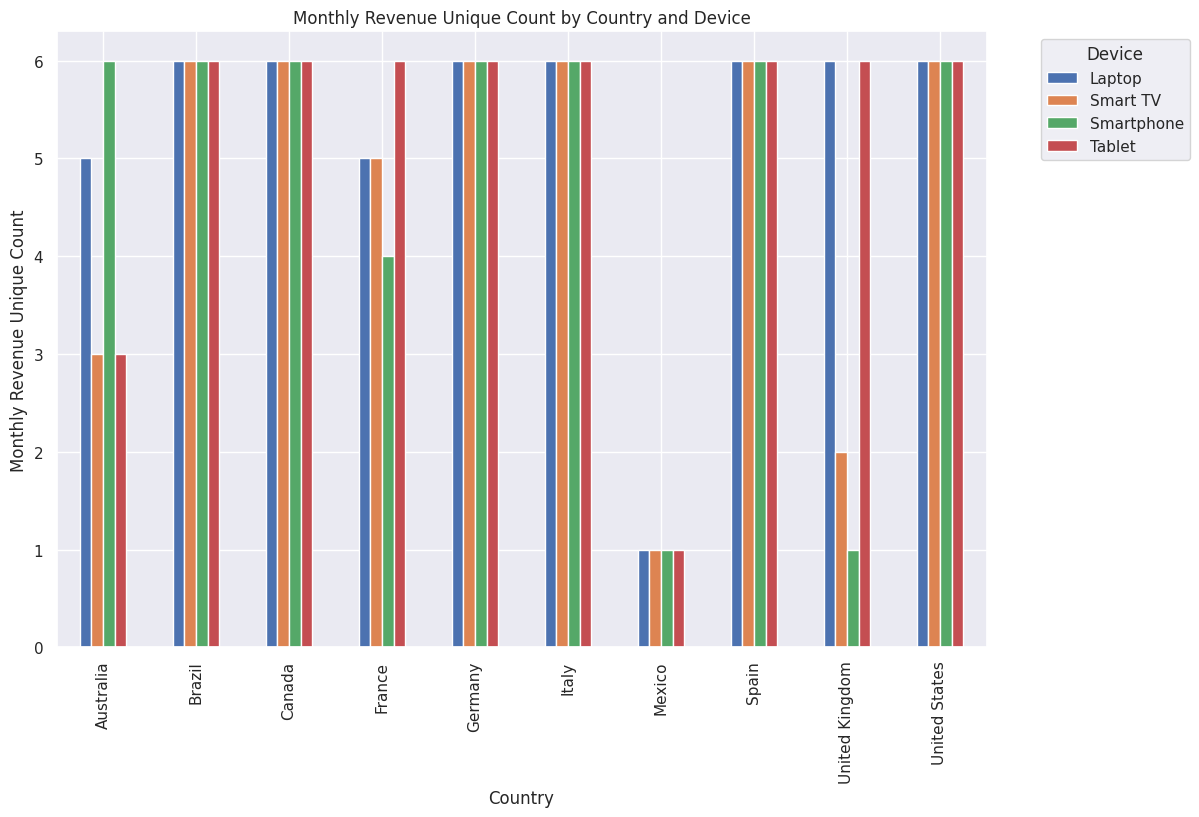

In [16]:
# Создание графика
fig, ax = plt.subplots(figsize=(12, 8))

# Группировка по странам и устройствам
grouped = rev_by_country_subscript.pivot_table(index='country', columns='device', values='monthly_revenue_unique_count', aggfunc='first')
grouped.plot(kind='bar', ax=ax)

# Настройка графика
ax.set_xlabel('Country')
ax.set_ylabel('Monthly Revenue Unique Count')
ax.set_title('Monthly Revenue Unique Count by Country and Device')
plt.legend(title='Device', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

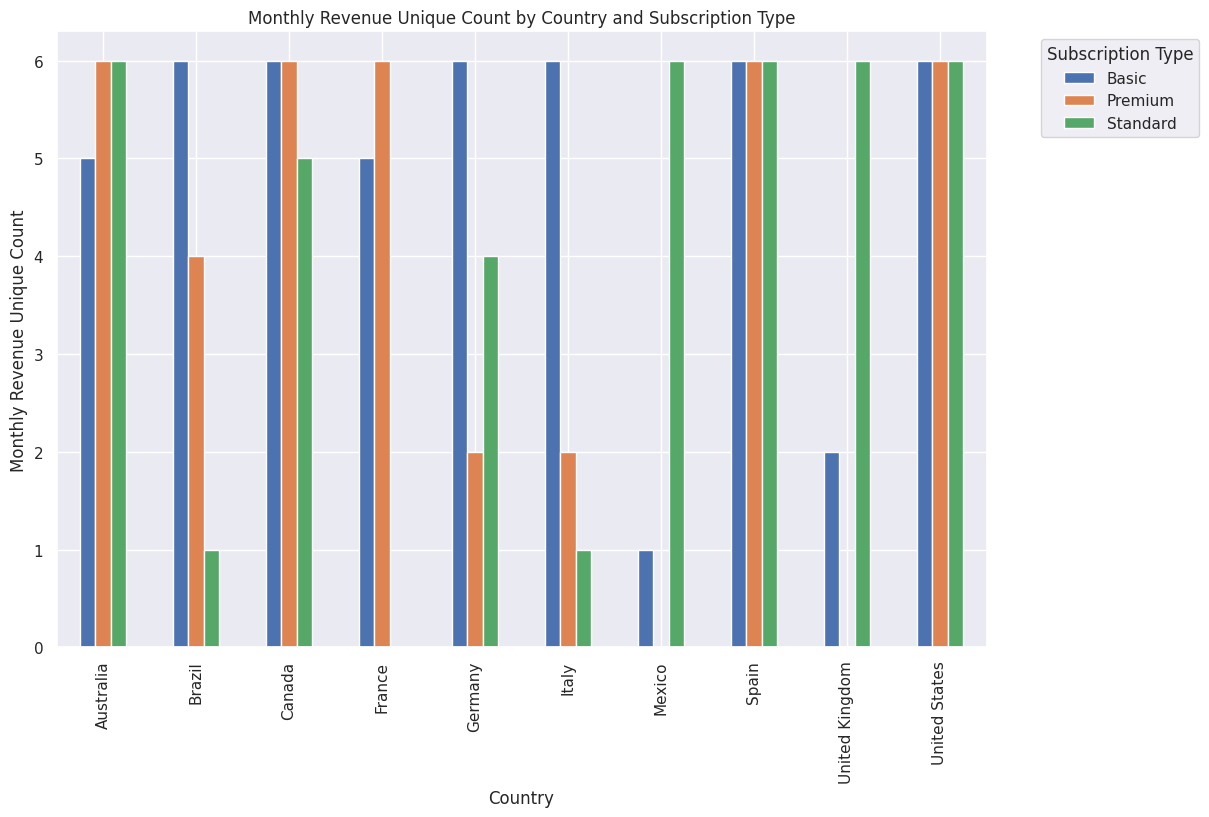

In [17]:
# Создание графика
fig, ax = plt.subplots(figsize=(12, 8))

# Группировка по странам и типу подписки
grouped = rev_by_country_subscript.pivot_table(index='country', columns='subscription_type', values='monthly_revenue_unique_count', aggfunc='first')
grouped.plot(kind='bar', ax=ax)

# Настройка графика
ax.set_xlabel('Country')
ax.set_ylabel('Monthly Revenue Unique Count')
ax.set_title('Monthly Revenue Unique Count by Country and Subscription Type')
plt.legend(title='Subscription Type', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

ВЫВОД:
 - мы посмотрели на географические параметры  каждого из тарифов и типов оплат, а так же на количество уникальных значений для разных девайсов по странам
- девайсы по странам по Уникальным типам оплат: видно, что в US, Canada, Brazil, Germany, Spain для каждого из типов девайсов справедливо наличие всех 6 уникальных сумм оплаты тарифов. Но в Mexico для каждого из девайсов справедлив всего уникальный тип оплаты, а в Australia 6 уникальных сумм справедливы только для смартфонов, в то время как для ноутбуков уже 5 разных уникальных стоимостей, а для смарт тв и планшетов всего 3. Во Франции только для планшетов есть 6 уникальных сумм на оплату, а для смартфонов4, в то время какдля ноутбуков и смарт тв существуют 5 типов оплаты. Интересный разброс по Великобритании: для ноутбуков и планшетов использовались все 6 типов оплаты, в тов имя как для телефона всего 1, а для смарт тв всего 2. Не вижу закономерности распределения уникальных оплат по девайсам, чтобы сказать, что уникальны оплаты не завесили бы от страны. Видимо внутренний региональный регламент формирования типов уникальных оплат имеет основное влияние на политику ценообразования.
- распределение уникальных оплат по тарифам по странам. Здесь хочу выделить Великобританию и Испанию: для этих стран справедливы все 6 уникальных значений оплаты по тарифам Basic, Standart и Premium, в то время как у Мексики в целом отсутствует тариф Premium, а для Basic существует только один тип оплаты. В Бразилии же 6 уникальных различных типов оплаты для Basic, уже 4 для Premium и всего один для Standart.

In [18]:
# Создание интерактивной карты мира
fig = px.choropleth(rev_by_country_subscript_map,
                    locations="country",
                    locationmode="country names",
                    color="monthly_revenue_unique_count",
                    hover_data=["monthly_revenue_unique_count"],
                    labels={'monthly_revenue_unique_count': 'Monthly Revenue Unique Count'},
                    title="Monthly Revenue Unique Count by Country",
                    projection="natural earth",
                    color_continuous_scale=[(0, 'green'), (0.5, 'yellow'), (1, 'red')],  # Цветовая карта
                    color_continuous_midpoint=3.5  # Средняя точка для цветовой карты
                   )



# Отображение карты
fig.show()

По визуализации видим, что в каждой стране представлен каждый из типов оплат тарифов.

In [19]:
# Определение функции для присвоения цветов в зависимости от значения 'monthly_revenue_unique_count'
def assign_color(value):
    if value in [5, 6]:
        return 'red'
    elif value in [3, 4]:
        return 'yellow'
    elif value in [1, 2]:
        return 'green'

# Создание нового столбца 'monthly_revenue_unique_count_color' с цветами в зависимости от значения 'monthly_revenue_unique_count'
rev_by_country_subscript['monthly_revenue_unique_count_color'] = rev_by_country_subscript['monthly_revenue_unique_count'].apply(assign_color)
rev_by_country_subscript.head()

,country,subscription_type,device,monthly_revenue_sum,monthly_revenue_unique,monthly_revenue_unique_count,monthly_revenue_unique_count_color
0,Australia,Basic,Laptop,99,"[10, 11, 13, 14, 15]",5,red
1,Australia,Basic,Smart TV,67,"[10, 12, 15]",3,yellow
2,Australia,Basic,Smartphone,129,"[10, 11, 12, 13, 14, 15]",6,red
3,Australia,Basic,Tablet,83,"[11, 12, 14]",3,yellow
4,Australia,Premium,Laptop,311,"[10, 11, 12, 13, 14, 15]",6,red


In [20]:
# Установка цветовой карты в соответствии с диапазоном значений 'Monthly Revenue Unique Count'
color_map = {'Basic': 'rgb(0,255,0)', 'Premium': 'rgb(255,255,0)', 'Standard': 'rgb(255,0,0)'}



# Создание интерактивной карты мира
fig = px.choropleth(rev_by_country_subscript,
                    locations="country",
                    locationmode="country names",
                    color="subscription_type",
                    hover_data=["monthly_revenue_unique_count"],
                    hover_name="country",
                    color_discrete_map=color_map,
                    labels={'monthly_revenue_unique_count': 'Monthly Revenue Unique Count'},
                    title="Monthly Revenue Unique Count by Country and Subscription Type",
                    projection="natural earth")

# Добавление выбора тарифов в легенду
subscription_types = ['Basic', 'Premium', 'Standard']
colors = ['rgb(0,255,0)', 'rgb(255,255,0)', 'rgb(255,0,0)']

# Отображение карты
fig.show()

При распределении и фильтрации по тарифам по представленным странам на карте видим, что в мексие всего 2 тарифа: Базовый и стандартный, нет премиального. Во Франции нет стандартного, есть только базовый и премиальный, а в Великобритании нет премиального, только базовый и стандартный. Либо в нашем датафрейме не собрана частично информация по данным странам.

посмотрим, сколько пользователей у нас распределено по странам

In [86]:
# Создание датафрейма netflix_user_number и подсчет количества пользователей по странам
netflix_user_number = netflix_usb.groupby('country')['user_id'].count().reset_index().copy()
netflix_user_number.columns = ['country', 'user_count']

netflix_user_number.sort_values(by='user_count', ascending=False)

,country,user_count
7,Spain,451
9,United States,451
2,Canada,317
0,Australia,183
1,Brazil,183
3,France,183
4,Germany,183
5,Italy,183
6,Mexico,183
8,United Kingdom,183


<Figure size 1200x800 with 0 Axes>

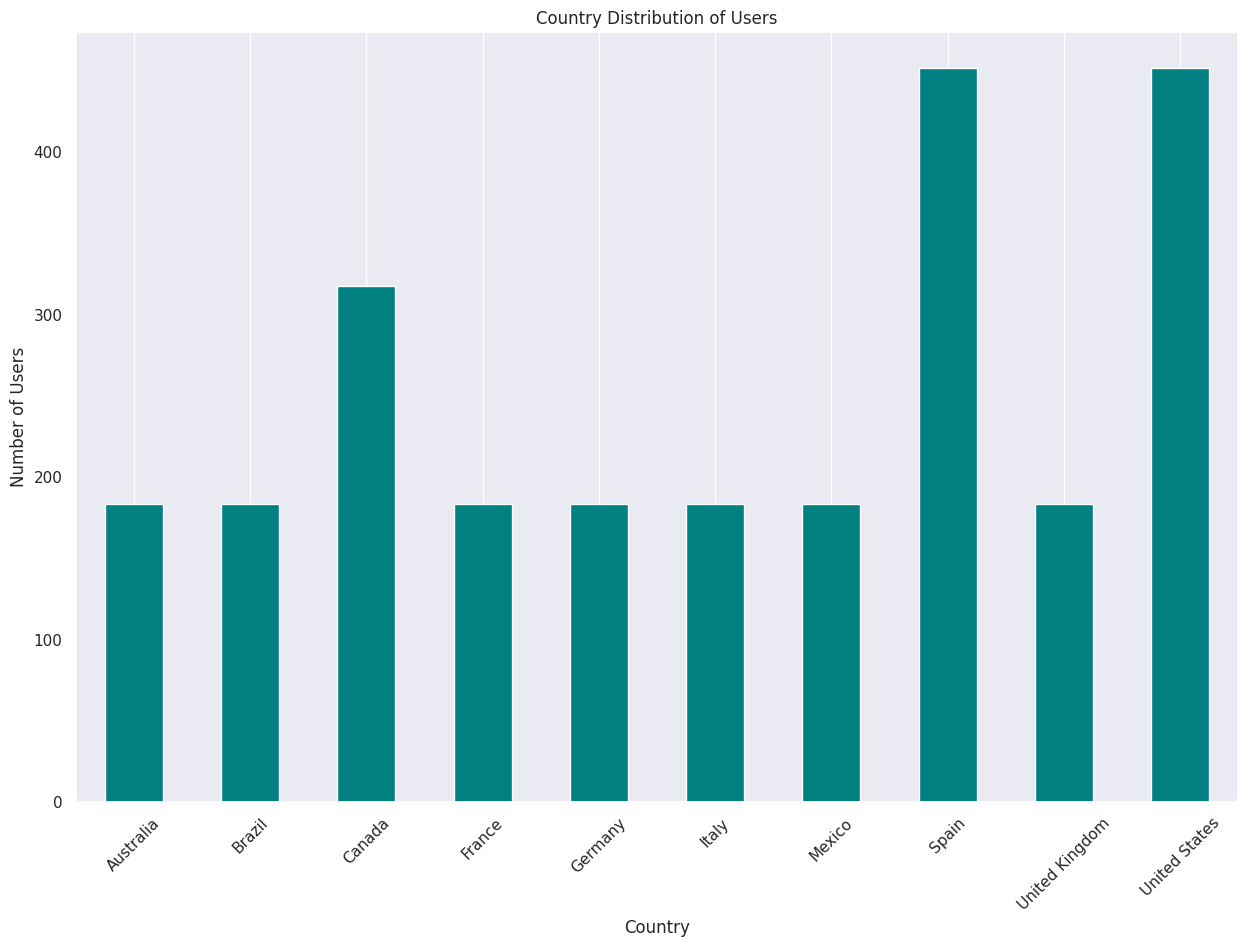

In [22]:
plt.figure(figsize=(12, 8))
netflix_user_number.plot(kind='bar',x='country', y='user_count', color='teal', legend=False)
plt.title('Country Distribution of Users')
plt.xlabel('Country')
plt.ylabel('Number of Users')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()


Топ-3 страны по количеству пользователей:
1. США - 451 юзер
2. Испания - 451 юзер
3. Канада - 317 юзер

В остальных странах одинаковое количество пользователей:
Италия, Великобритания, Австралия, Бразилия, Франция,Германия и Мексика по 183 пользователя.


Далее посмотрим как по девайсам распределяется количество покупок:

In [23]:
# Создание датафрейма netflix_device и подсчет суммы ежемесячного дохода для каждого устройства
netflix_device = netflix_usb.groupby('device')['monthly_revenue'].sum().reset_index().copy()

# Построение стилизованного интерактивного пайчарта
fig = px.pie(netflix_device, values='monthly_revenue', names='device',
             title='Monthly Revenue by Device',
             color_discrete_sequence=px.colors.qualitative.Set3,
             hole=0.3,
             labels={'device': 'Device', 'monthly_revenue': 'Monthly Revenue'},
             hover_data=['monthly_revenue']
            )

fig.update_traces(textposition='inside', textinfo='percent+label')

fig.show()

Распределение равномерное, примерно по 1/4 всех оплат приходится на каждый из девайсов.

Посмотирим на данные распределение пользователей по половой принадлежности:

In [91]:
netflix_gender = netflix_usb.copy()
netflix_gender.head()

,user_id,subscription_type,monthly_revenue,join_date,last_payment_date,country,age,gender,device,plan_duration_months
0,1,Basic,10,2022-01-15,2023-10-06,United States,28,Male,Smartphone,1
1,2,Premium,15,2021-05-09,2023-06-22,Canada,35,Female,Tablet,1
2,3,Standard,12,2023-02-28,2023-06-27,United Kingdom,42,Male,Smart TV,1
3,4,Standard,12,2022-10-07,2023-06-26,Australia,51,Female,Laptop,1
4,5,Basic,10,2023-01-05,2023-06-28,Germany,33,Male,Smartphone,1


In [25]:
# Подсчет количества мужчин и женщин
gender_counts = netflix_gender['gender'].value_counts()

# Создание данных для пайчарта
labels = gender_counts.index
values = gender_counts.values

# Построение пайчарта с объемным видом и небольшим разделением
fig = go.Figure(data=[go.Pie(labels=labels, values=values, hole=0.3, pull=[0, 0.1])])

# Настройка цветов для мужчин и женщин
fig.update_traces(marker=dict(colors=['pink', 'blue']), textinfo='label+percent')

# Настройка макета для заголовка в центре
fig.update_layout(title={'text': 'Gender Distribution on Netflix', 'x': 0.5, 'y': 0.9, 'xanchor': 'center', 'yanchor': 'top'})

# Добавление подписи к легенде
fig.update_layout(legend_title_text='Gender')

# Отображение пайчарта
fig.show()

По графику видим примерно одинаковое распределение между мужчинами и женщинами, тут нет больших отклонений. Теперь посмотрим на суммы покупок, совершенные мужчинами и женщинами в исследуемый период:

In [26]:
# Группируем данные по полу и суммируем суммы покупок
netflix_gender_grouped = netflix_usb.copy()
grouped_data = netflix_gender_grouped.groupby('gender')['monthly_revenue'].sum().reset_index()

# Создаем интерактивный пай-чарт
fig = px.pie(grouped_data, values='monthly_revenue', names='gender',
             title='Monthly Revenue Distribution by Gender',
             hover_data=['monthly_revenue'],
             color_discrete_sequence=['pink', 'blue'])

# Настройка макета
fig.update_traces(textinfo='percent+label', pull=[0, 0.1])

# Отображение интерактивного пай-чарта
fig.show()

И опять примерно равное количество как мужчин, так и женщин. Видимо целевая аудитория формируется не зависимо от половой принадлежности.

теперь посмотрим по странам и по тарифам, как распределяется количество мужчин и женщин:

In [92]:
netflix_gender = netflix_gender.groupby(['country', 'subscription_type', 'gender']).size().unstack().reset_index().fillna(0)
netflix_gender = netflix_gender.rename(columns={'gender': 'index'})

netflix_gender.head()

gender,country,subscription_type,Female,Male
0,Australia,Basic,16,15
1,Australia,Premium,45,56
2,Australia,Standard,28,23
3,Brazil,Basic,78,68
4,Brazil,Premium,16,17


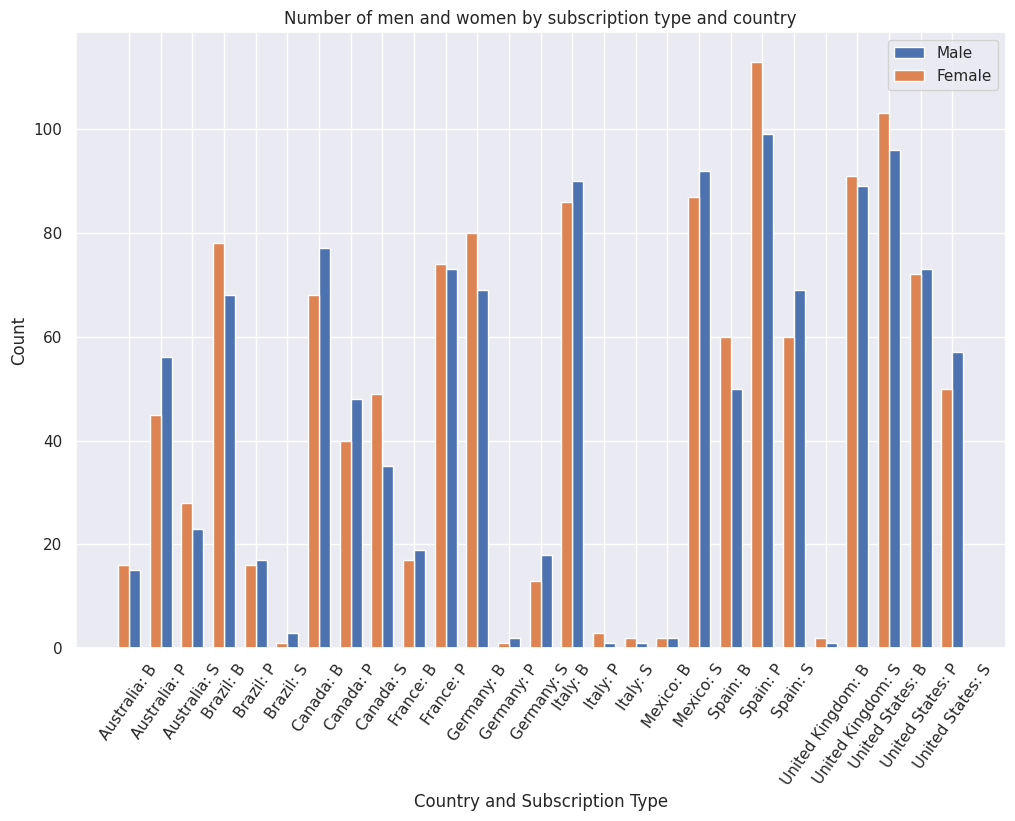

In [28]:
# Создаем переменные для данных графика
countries = netflix_gender['country'].unique()

fig, ax = plt.subplots(figsize=(12, 8))

bar_width = 0.35
index = range(len(netflix_gender))

bar1 = ax.bar([i + bar_width for i in index], netflix_gender['Male'], bar_width, label='Male')
bar2 = ax.bar(index, netflix_gender['Female'], bar_width, label='Female')

ax.set_xticks([i + bar_width / 2 for i in index])
ax.set_xticklabels([f"{country}: {subscription[0]}" for country, subscription in zip(netflix_gender['country'], netflix_gender['subscription_type'])])
ax.set_xlabel('Country and Subscription Type')
ax.set_ylabel('Count')

# Добавляем заголовок
plt.title('Number of men and women by subscription type and country')

ax.legend()
plt.xticks(rotation=55)

plt.show()

Вывод: во всех странах примерно равное распределение количества пользователей мужского и женского пола. Однако в премиальном тарифе в Испании больше пользователей женского пола, как и базовом тарифае в Штатах и в стандартном тарифе в Австралии. При этом в премиальном тарифе в Австралии и базовом и премиальном тарифе в канаде явно больше пользователей мужского пола.


Узнаем, какая средняя стоимость оплаты по каждому из тарифов для мужчин и женщин:

In [29]:
gender_avg_price = netflix_usb.copy()

# Группировка данных по стране и полу, подсчет средней стоимости тарифа
avg_price_by_country_gender = gender_avg_price.groupby(['country', 'subscription_type', 'gender'])['monthly_revenue'].mean().reset_index().copy()
avg_price_by_country_gender['monthly_revenue'] = avg_price_by_country_gender['monthly_revenue'].round(2)

# Создаем сводную таблицу, где 'female' и 'male' будут столбцами
avg_price_by_country_gender = avg_price_by_country_gender.pivot_table(index=['country', 'subscription_type'], columns='gender', values='monthly_revenue', fill_value=0).reset_index()

# Выводим результат
avg_price_by_country_gender.head()

gender,country,subscription_type,Female,Male
0,Australia,Basic,11.94,12.47
1,Australia,Premium,12.40,12.43
2,Australia,Standard,12.57,12.48
3,Brazil,Basic,12.19,12.84
4,Brazil,Premium,12.12,12.71


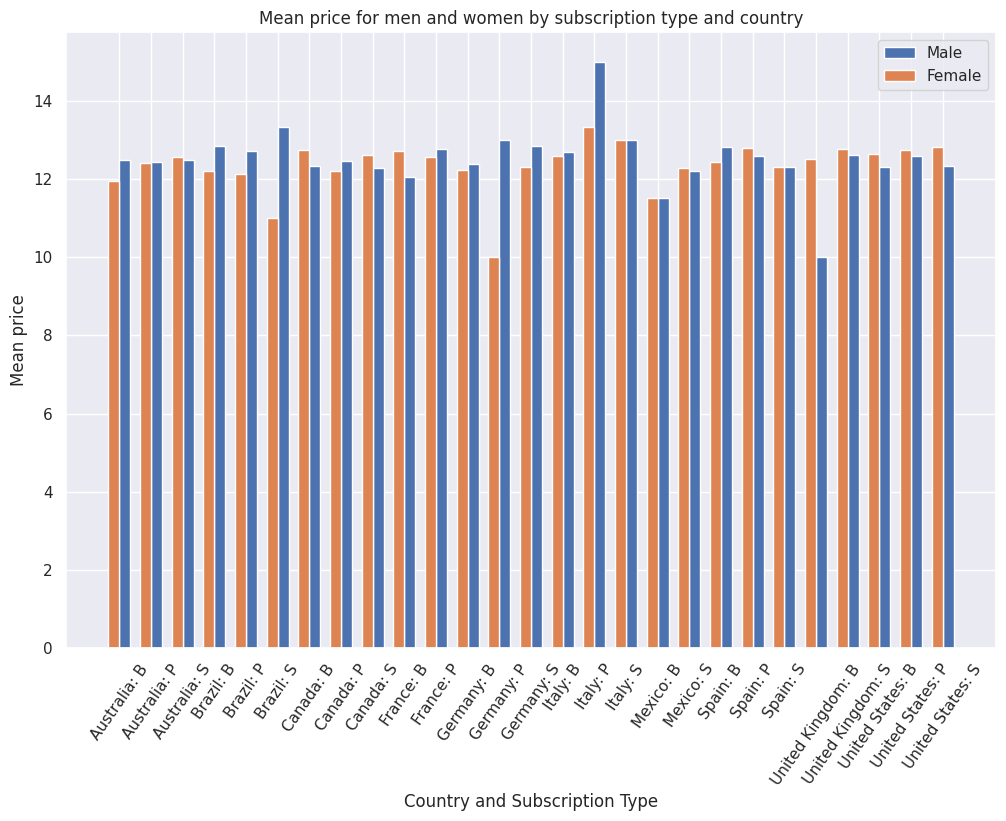

In [30]:
# Создаем переменные для данных графика
countries = avg_price_by_country_gender['country'].unique()

fig, ax = plt.subplots(figsize=(12, 8))

bar_width = 0.35
index = range(len(avg_price_by_country_gender))

bar1 = ax.bar([i + bar_width for i in index], avg_price_by_country_gender['Male'], bar_width, label='Male')
bar2 = ax.bar(index, avg_price_by_country_gender['Female'], bar_width, label='Female')

ax.set_xticks([i + bar_width / 2 for i in index])
ax.set_xticklabels([f"{country}: {subscription[0]}" for country, subscription in zip(avg_price_by_country_gender['country'], avg_price_by_country_gender['subscription_type'])])
ax.set_xlabel('Country and Subscription Type')
ax.set_ylabel('Mean price')

# Добавляем заголовок
plt.title('Mean price for men and women by subscription type and country')

ax.legend()
plt.xticks(rotation=55)

plt.show()

In [31]:
gender_avg_price.head()

,user_id,subscription_type,monthly_revenue,join_date,last_payment_date,country,age,gender,device,plan_duration_months
0,1,Basic,10,2022-01-15,2023-10-06,United States,28,Male,Smartphone,1
1,2,Premium,15,2021-05-09,2023-06-22,Canada,35,Female,Tablet,1
2,3,Standard,12,2023-02-28,2023-06-27,United Kingdom,42,Male,Smart TV,1
3,4,Standard,12,2022-10-07,2023-06-26,Australia,51,Female,Laptop,1
4,5,Basic,10,2023-01-05,2023-06-28,Germany,33,Male,Smartphone,1


In [32]:
# Группировка данных по странам и расчет общей прибыли
gender_revenue_unique = netflix_usb.copy()
gender_revenue_unique['monthly_revenue_sum'] = gender_revenue_unique['monthly_revenue']
gender_revenue_unique['monthly_revenue_unique'] = gender_revenue_unique['monthly_revenue']
gender_revenue_unique['monthly_revenue_unique_count'] = gender_revenue_unique['monthly_revenue']
gender_revenue_unique = gender_revenue_unique.groupby(['country', 'subscription_type', 'gender']).agg({'monthly_revenue_sum': 'sum', 'monthly_revenue_unique': 'unique', 'monthly_revenue_unique_count': 'nunique'}).reset_index()


# Сортировка по убыванию прибыли, чтобы выявить основные источники доходов
gender_revenue_unique.sort_values(by=['country', 'monthly_revenue_sum'], ascending=False).head()

for i in gender_revenue_unique['monthly_revenue_unique']:
  i.sort()

gender_revenue_unique.head()

,country,subscription_type,gender,monthly_revenue_sum,monthly_revenue_unique,monthly_revenue_unique_count
0,Australia,Basic,Female,191,"[10, 11, 12, 13, 14, 15]",6
1,Australia,Basic,Male,187,"[10, 11, 12, 13, 14, 15]",6
2,Australia,Premium,Female,558,"[10, 11, 12, 13, 14, 15]",6
3,Australia,Premium,Male,696,"[10, 11, 12, 13, 14, 15]",6
4,Australia,Standard,Female,352,"[10, 11, 12, 13, 14, 15]",6


In [33]:
# Создание датафрейма для хранения строк, где значения monthly_revenue_unique различаются для мужчин и женщин
various_unique_meanings = pd.DataFrame(columns=gender_revenue_unique.columns)

# Группировка данных по 'country' и 'subscription_type'
grouped = gender_revenue_unique.groupby(['country', 'subscription_type'])

# Итерация по группам данных и сравнение значений monthly_revenue_unique для мужчин и женщин
for name, group in grouped:
    male_data = group[group['gender'] == 'Male']
    female_data = group[group['gender'] == 'Female']

    if not male_data.empty and not female_data.empty:
        male_values = set(male_data['monthly_revenue_unique'].iloc[0])
        female_values = set(female_data['monthly_revenue_unique'].iloc[0])

        if male_values != female_values:
            various_unique_meanings = pd.concat([various_unique_meanings, group])

various_unique_meanings.head()


,country,subscription_type,gender,monthly_revenue_sum,monthly_revenue_unique,monthly_revenue_unique_count
10,Brazil,Standard,Female,11,[11],1
11,Brazil,Standard,Male,40,"[12, 14]",2
18,France,Basic,Female,216,"[11, 12, 13, 14, 15]",5
19,France,Basic,Male,229,"[10, 11, 12, 13, 14, 15]",6
24,Germany,Premium,Female,10,[10],1


In [34]:
various_unique_meanings

,country,subscription_type,gender,monthly_revenue_sum,monthly_revenue_unique,monthly_revenue_unique_count
10,Brazil,Standard,Female,11,[11],1
11,Brazil,Standard,Male,40,"[12, 14]",2
18,France,Basic,Female,216,"[11, 12, 13, 14, 15]",5
19,France,Basic,Male,229,"[10, 11, 12, 13, 14, 15]",6
24,Germany,Premium,Female,10,[10],1
25,Germany,Premium,Male,26,"[11, 15]",2
26,Germany,Standard,Female,160,"[10, 11, 12, 13, 15]",5
27,Germany,Standard,Male,231,"[10, 11, 13, 14, 15]",5
30,Italy,Premium,Female,40,"[10, 15]",2
31,Italy,Premium,Male,15,[15],1


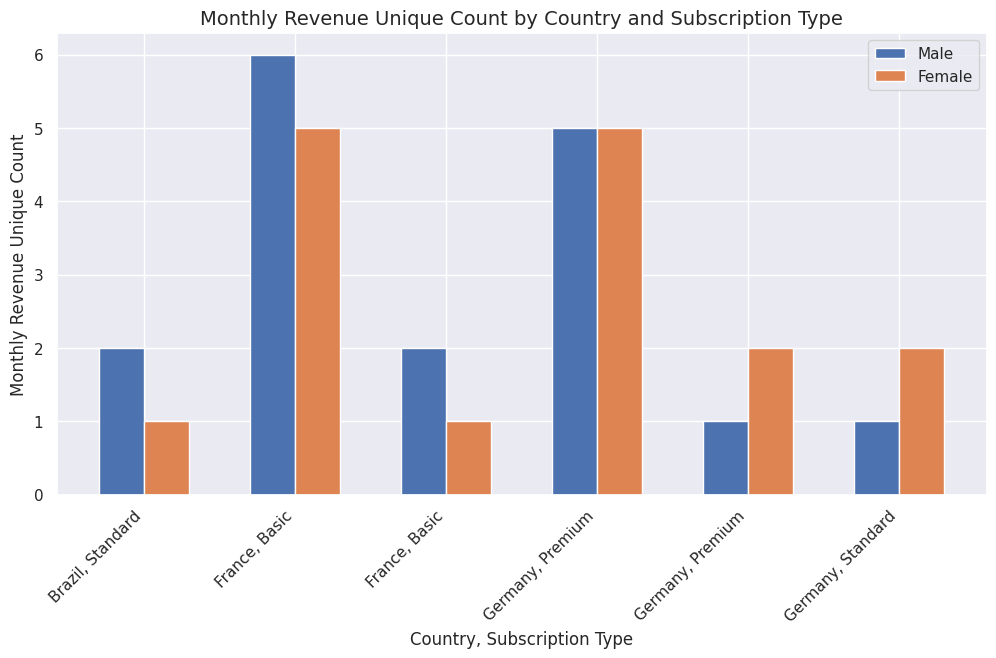

In [35]:
# Группируем данные по странам, тарифам и полу, суммируя количество уникальных значений
grouped_data = various_unique_meanings.groupby(['country', 'subscription_type', 'gender']).sum().reset_index()

# Создаем столбчатую диаграмму
fig, ax = plt.subplots(figsize=(12, 6))
barWidth = 0.3

# Строим столбцы для мужчин
bars1 = grouped_data[grouped_data['gender'] == 'Male']['monthly_revenue_unique_count']
r1 = range(len(bars1))
ax.bar([x - barWidth/2 for x in r1], bars1, width=barWidth, label='Male')

# Строим столбцы для женщин
bars2 = grouped_data[grouped_data['gender'] == 'Female']['monthly_revenue_unique_count']
r2 = [x + barWidth for x in r1]
ax.bar([x + barWidth/2 for x in r1], bars2, width=barWidth, label='Female')

# Настройка графика
ax.set_xticklabels([f"{c}, {s}" for c, s in zip(grouped_data['country'], grouped_data['subscription_type'])], rotation=45, ha='right')
ax.set_xlabel('Country, Subscription Type', fontsize=12)  # Добавляем подпись к оси X
ax.set_ylabel('Monthly Revenue Unique Count', fontsize=12)  # Добавляем подпись к оси Y
ax.set_title('Monthly Revenue Unique Count by Country and Subscription Type', fontsize=14)  # Добавляем заголовок
ax.legend()  # Добавляем легенду

plt.show()

проведем т-тест -  в рамках каждой страны и посмотреть кто больше платит - мужчины и женщины:

In [36]:
netflix_gender_ttest = netflix_usb.copy()
netflix_gender_ttest.groupby(['country', 'gender', 'subscription_type', 'monthly_revenue'])
netflix_gender_ttest.head()

,user_id,subscription_type,monthly_revenue,join_date,last_payment_date,country,age,gender,device,plan_duration_months
0,1,Basic,10,2022-01-15,2023-10-06,United States,28,Male,Smartphone,1
1,2,Premium,15,2021-05-09,2023-06-22,Canada,35,Female,Tablet,1
2,3,Standard,12,2023-02-28,2023-06-27,United Kingdom,42,Male,Smart TV,1
3,4,Standard,12,2022-10-07,2023-06-26,Australia,51,Female,Laptop,1
4,5,Basic,10,2023-01-05,2023-06-28,Germany,33,Male,Smartphone,1


Формулируем нулевую и альтернативную гипотезы:

Нулевая гипотеза (H0): Средние доходы, полученные от типов тарифов, у мужчин и женщин в каждой стране равны.

Альтернативная гипотеза (H1): Средние доходы, полученные от типов тарифов, у мужчин и женщин в каждой стране различаются.

Другими словами, нулевая гипотеза не предполагает отсутствие различий в средних доходах между мужчинами и женщинами для каждой страны и типа тарифа, а альтернативная гипотеза предполагает наличие таких различий.

Далее, проведя t-тест и анализируя полученные результаты (значения t-статистики и p-значения), можно будет сделать вывод о том, следует ли отвергнуть нулевую гипотезу в пользу альтернативной:

In [37]:
from scipy.stats import ttest_ind
# Группировка данных по стране, типу тарифа и полу и применение t-теста
results = []

for (country, subscription_type), group in netflix_gender_ttest.groupby(['country', 'subscription_type']):
    male_data = group[group['gender'] == 'Male']['monthly_revenue']
    female_data = group[group['gender'] == 'Female']['monthly_revenue']

    if len(male_data) >= 20 and len(female_data) >= 20:  # Проверяем, что есть хотя бы по двадцать значений для каждого пола
        t_stat, p_val = ttest_ind(male_data, female_data, equal_var=False)

        result = {
            'country': country,
            'subscription_type': subscription_type,
            'p-value': p_val,
            'Null Hypothesis': 'Отклонена' if p_val < 0.05 else 'Не отклонена'
        }
        results.append(result)

# Вывод результатов
results_df = pd.DataFrame(results)
results_df

,country,subscription_type,p-value,Null Hypothesis
0,Australia,Premium,0.932993,Не отклонена
1,Australia,Standard,0.832566,Не отклонена
2,Brazil,Basic,0.023080,Отклонена
3,Canada,Basic,0.125831,Не отклонена
4,Canada,Premium,0.456494,Не отклонена
5,Canada,Standard,0.377269,Не отклонена
6,France,Premium,0.481901,Не отклонена
7,Germany,Basic,0.530654,Не отклонена
8,Italy,Basic,0.712301,Не отклонена
9,Mexico,Standard,0.774165,Не отклонена


множественная проверка гипотез:
необходимо применять поправку Бонеферони (Холма Бонферони) для
при зависимом тестировании множетсва тестов если решение принимается по всем тестам одно

Только в базовом тарифе в Бразилии мы нашли разницу между оплатами для мужчинн и женщин

дальше посмотрим сколько людей мужского и женского пола в бразилии в этом тарифе, когда они заходили (таймлайн)



In [38]:
netflix_brazil_basic = netflix_usb[netflix_usb['country'] == 'Brazil'][['subscription_type', 'join_date', 'monthly_revenue', 'gender']].copy()
netflix_brazil_basic = netflix_brazil_basic[netflix_brazil_basic['subscription_type'] == 'Basic']
netflix_brazil_basic.head()

,subscription_type,join_date,monthly_revenue,gender
16,Basic,2022-01-24,10,Female
26,Basic,2022-08-29,10,Female
36,Basic,2022-09-14,10,Female
46,Basic,2022-05-10,10,Female
56,Basic,2022-01-10,10,Female


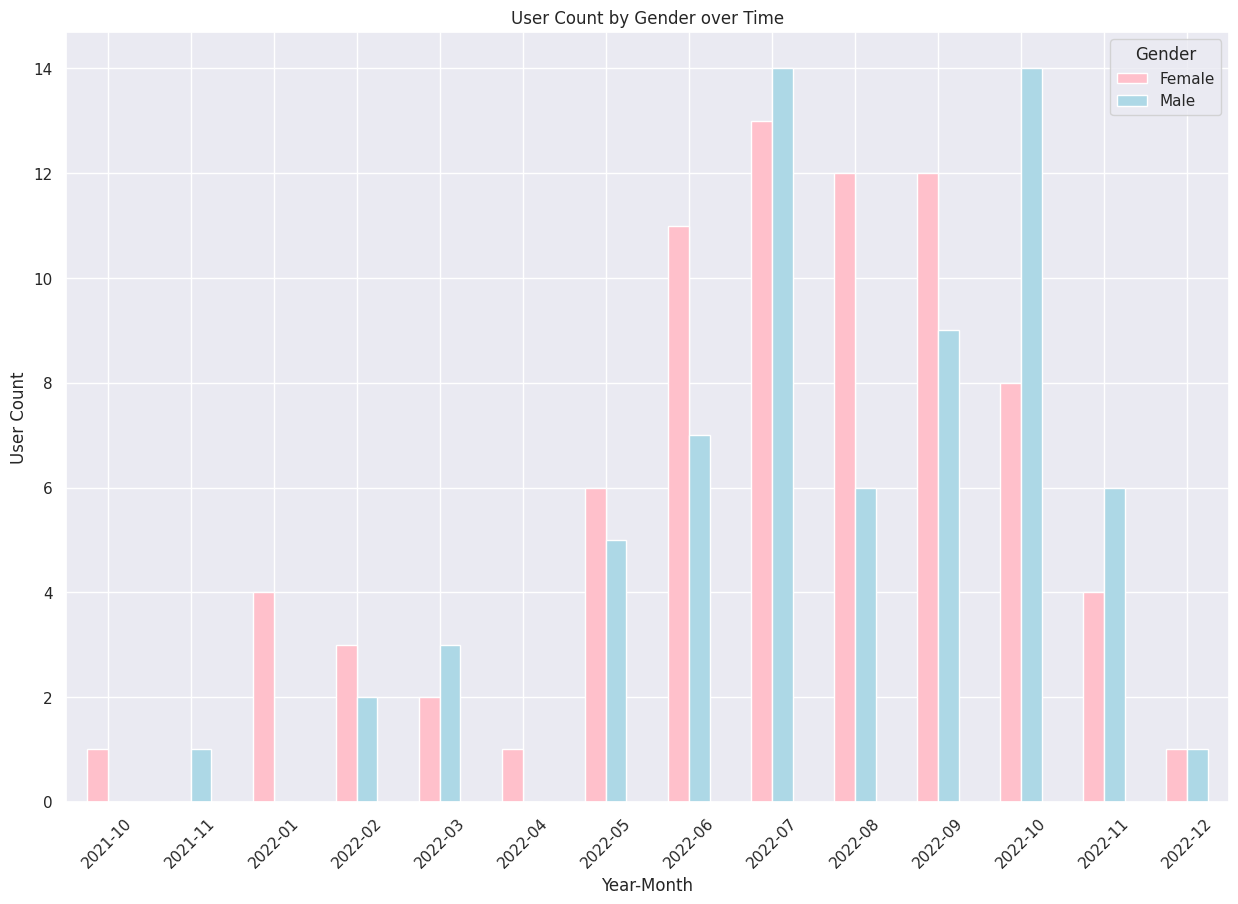

In [39]:
netflix_brazil_basic['join_date'] = pd.to_datetime(netflix_brazil_basic['join_date'])
netflix_brazil_basic['year_month'] = netflix_brazil_basic['join_date'].dt.to_period('M')

user_count_by_gender = netflix_brazil_basic.groupby(['year_month', 'gender']).size().unstack()

fig, ax = plt.subplots()
user_count_by_gender.plot(kind='bar', stacked=False, color=['pink', 'lightblue'], ax=ax)
plt.xlabel('Year-Month')
plt.ylabel('User Count')
plt.title('User Count by Gender over Time')
plt.legend(title='Gender')
plt.xticks(rotation=45)
plt.show()

выведем среднюю цену в месяц и посмотри по средней цене по месяцам по мужчинам и женщинам есть ли разница:

In [40]:
# скопируем исходный датафрейм
netflix_brazil_basic_avg_price = netflix_brazil_basic.copy()

# преобразуем столбцы дат в формат datetime
netflix_brazil_basic_avg_price['join_date'] = pd.to_datetime(netflix_brazil_basic_avg_price['join_date'])
netflix_brazil_basic_avg_price['year_month'] = pd.to_datetime(netflix_brazil_basic_avg_price['year_month'].astype(str), format='%Y-%m')

# создаем датафрейм с средней ценой в месяц и анализируем разницу между мужчинами и женщинами
result = netflix_brazil_basic_avg_price.groupby(['year_month', 'gender'])['monthly_revenue'].mean().unstack()

result

gender,Female,Male
year_month,,
2021-10-01,15.000000,NaN
2021-11-01,NaN,10.000000
2022-01-01,11.500000,NaN
2022-02-01,12.666667,14.000000
2022-03-01,11.500000,12.666667
2022-04-01,13.000000,NaN
2022-05-01,11.500000,12.800000
2022-06-01,11.545455,12.428571
2022-07-01,12.230769,13.142857


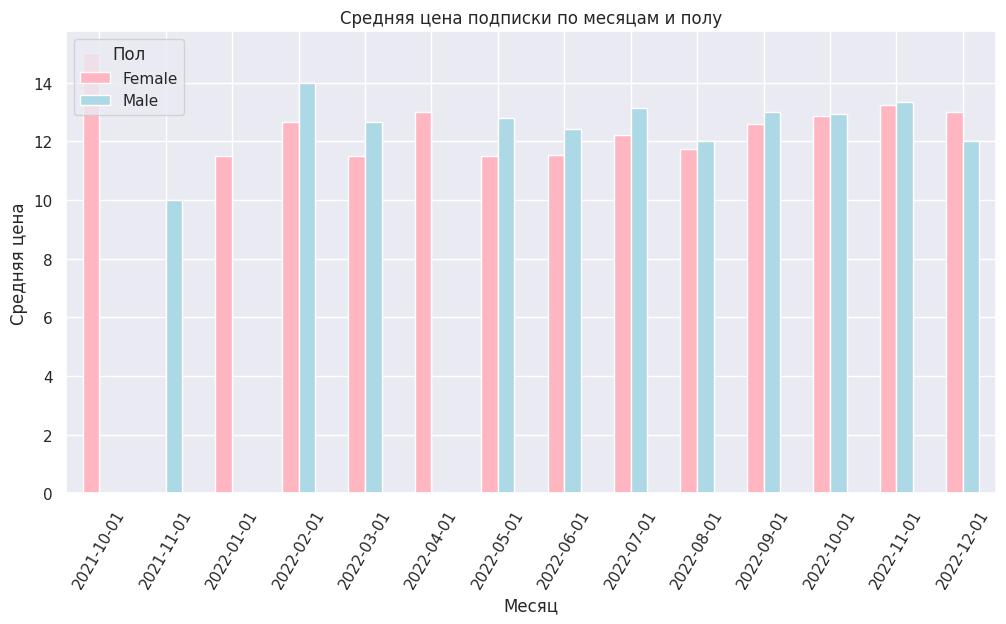

In [41]:
# Группируем данные
result = netflix_brazil_basic_avg_price.groupby(['year_month', 'gender'])['monthly_revenue'].mean().unstack()
# Преобразование индекса в формат даты без времени
result.index = pd.to_datetime(result.index).date

# Построение столбчатой диаграммы с разными цветами для мужчин и женщин
result.plot(kind='bar', figsize=(12, 6), color=['lightpink', 'lightblue'])
plt.title('Средняя цена подписки по месяцам и полу')
plt.xlabel('Месяц')
plt.ylabel('Средняя цена')
plt.legend(title='Пол', loc='upper left')

# Поворот подписей по оси X на 60 градусов
plt.xticks(rotation=60)

plt.show()

вывод: есть два месяца (октябрь 2021 и январь 2022 годов) когда и правда тариф был куплен только женщинами. Но так же есть декабрь 2021 года, когда только мужчинам был доступен тариф для покупки. При этом средняя стоимость тарифа для женщин и мужчин примерно одинакова в остальные месяцы.
глобально можем контстатировать, что такое распределение покупок тарифа между мужчинами и женщинами оказалось статиситчески значимым.

In [42]:
netflix_mean_profit = netflix_usb.copy()
netflix_mean_profit.head()

,user_id,subscription_type,monthly_revenue,join_date,last_payment_date,country,age,gender,device,plan_duration_months
0,1,Basic,10,2022-01-15,2023-10-06,United States,28,Male,Smartphone,1
1,2,Premium,15,2021-05-09,2023-06-22,Canada,35,Female,Tablet,1
2,3,Standard,12,2023-02-28,2023-06-27,United Kingdom,42,Male,Smart TV,1
3,4,Standard,12,2022-10-07,2023-06-26,Australia,51,Female,Laptop,1
4,5,Basic,10,2023-01-05,2023-06-28,Germany,33,Male,Smartphone,1


In [43]:
netflix_mean_profit.groupby('country')['monthly_revenue'].mean()

country
Australia         12.409836
Brazil            12.486339
Canada            12.460568
France            12.606557
Germany           12.349727
Italy             12.661202
Mexico            12.224044
Spain             12.554324
United Kingdom    12.666667
United States     12.558758
Name: monthly_revenue, dtype: float64

In [44]:
# Извлечение года из столбцов join_date и last_payment_date
netflix_mean_profit['join_year'] = pd.to_datetime(netflix_mean_profit['join_date']).dt.year
netflix_mean_profit['last_payment_year'] = pd.to_datetime(netflix_mean_profit['last_payment_date']).dt.year

# Объединение данных по году и стране и вычисление средней прибыли
netflix_mean_profit_by_year = netflix_mean_profit.groupby(['country', 'join_year'])['monthly_revenue'].mean().reset_index()
netflix_mean_profit_by_year.head()

,country,join_year,monthly_revenue
0,Australia,2022,12.41989
1,Australia,2023,11.50000
2,Brazil,2021,13.00000
3,Brazil,2022,12.47486
4,Canada,2021,15.00000


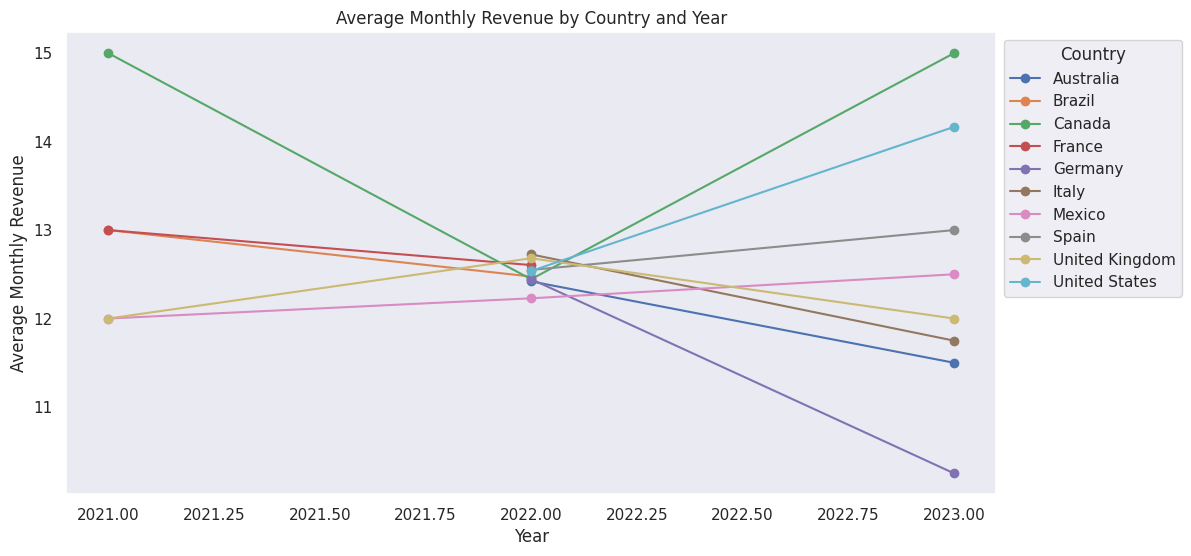

In [45]:
# Построение линейного графика для каждой страны
fig, ax = plt.subplots(figsize=(12, 6))
for country in netflix_mean_profit_by_year['country'].unique():
    data = netflix_mean_profit_by_year[netflix_mean_profit_by_year['country'] == country]
    ax.plot(data['join_year'], data['monthly_revenue'], label=country, marker='o')

ax.set_xlabel('Year')
ax.set_ylabel('Average Monthly Revenue')
ax.set_title('Average Monthly Revenue by Country and Year')
ax.legend(title='Country', bbox_to_anchor=(1, 1))
plt.grid()
plt.show()

In [46]:
# Определяем цветовую палитру
colorscale = [[0, 'red'], [0.5, 'yellow'], [1.0, 'blue']]

# Создаем кастомную последовательность годов
custom_year_sequence = [2021, 2022, 2023]

# Строим интерактивную карту с кастомной последовательностью годов
fig = px.choropleth(netflix_mean_profit_by_year,
                    locations='country',
                    locationmode='country names',
                    color='monthly_revenue',
                    color_continuous_scale=colorscale,
                    range_color=[10, 14],
                    animation_frame='join_year',
                    title='Average Monthly Revenue by Country',
                    labels={'monthly_revenue': 'Average Monthly Revenue', 'join_year': 'Year'},
                    category_orders={'join_year': custom_year_sequence}  # Задаем кастомную последовательность годов
                   )

# Отображаем карту
fig.show()

In [47]:
netflix_mean_profit['join_date'] = pd.to_datetime(netflix_mean_profit['join_date'])
netflix_mean_profit['join_month_year'] = netflix_mean_profit['join_date'].dt.to_period('M')

netflix_mean_profit_by_month = netflix_mean_profit.groupby(['country', 'join_month_year'])['monthly_revenue'].mean().reset_index()
netflix_mean_profit_by_month['monthly_revenue'] = netflix_mean_profit_by_month['monthly_revenue'].round(2)
netflix_mean_profit_by_month.head()

,country,join_month_year,monthly_revenue
0,Australia,2022-01,12.75
1,Australia,2022-02,11.67
2,Australia,2022-03,12.62
3,Australia,2022-04,13.53
4,Australia,2022-05,13.75


In [48]:
netflix_mean_profit_by_month = netflix_mean_profit_by_month.sort_values(by='join_month_year')

сделай такую же разбивку на по месяцам

In [49]:
# Строим интерактивную карту
fig = px.choropleth(netflix_mean_profit_by_month,
                    locations='country',
                    locationmode='country names',
                    color='monthly_revenue',
                    color_continuous_scale='RdBu',
                    title='Average Monthly Revenue by Country',
                    labels={'monthly_revenue': 'Average Monthly Revenue'},
                    animation_frame='join_month_year',  # Переключение по месяцам и годам
                    range_color=[netflix_mean_profit_by_month['monthly_revenue'].min(), netflix_mean_profit_by_month['monthly_revenue'].max()]
                   )

fig.show()

динамика дает информацию о том, что даже в штатах с высокой стоимостью тарифов есть периоды с понижением стоимости тарифов, видимо в рамках маркетинговых стратегий

доработь: посмотри на каждую страну с тарифом в разрезе пол/возрат/устройства/когда купил тариф (join_date)

In [50]:
# Группировка пользователей по стране и тарифу с данными о поле, возрасте, устройствах и датах приобретения тарифа
grouped_data = netflix_usb.groupby(['country', 'subscription_type']).agg({
    'gender': lambda x: ', '.join(x),
    'age': 'mean',
    'device': lambda x: ', '.join(x),
    'join_date': lambda x: ', '.join(x.astype(str))
}).reset_index()
grouped_data.head()

,country,subscription_type,gender,age,device,join_date
0,Australia,Basic,"Male, Female, Male, Male, Female, Male, Female...",37.935484,"Smartphone, Tablet, Laptop, Laptop, Tablet, Sm...","2022-01-08, 2022-11-03, 2022-04-21, 2022-03-06..."
1,Australia,Premium,"Female, Male, Male, Male, Male, Male, Male, Fe...",38.613861,"Smartphone, Smartphone, Laptop, Smartphone, La...","2022-12-14, 2022-03-19, 2022-08-06, 2022-11-18..."
2,Australia,Standard,"Female, Male, Male, Male, Male, Male, Male, Ma...",38.098039,"Laptop, Tablet, Smartphone, Tablet, Smartphone...","2022-10-07, 2022-03-04, 2022-05-25, 2022-04-26..."
3,Brazil,Basic,"Female, Female, Female, Female, Female, Female...",38.239726,"Laptop, Smart TV, Laptop, Smart TV, Laptop, Sm...","2022-01-24, 2022-08-29, 2022-09-14, 2022-05-10..."
4,Brazil,Premium,"Female, Male, Female, Female, Male, Female, Fe...",38.969697,"Smartphone, Smart TV, Smartphone, Tablet, Lapt...","2022-12-25, 2021-12-28, 2022-09-30, 2022-07-07..."


In [51]:
# Группируем данные по стране, тарифу и полу, считаем количество пользователей
grouped_for_dots = netflix_usb.groupby(['country', 'subscription_type', 'gender']).size().reset_index(name='users_count')
grouped_for_dots.rename(columns={'gender': 'gender_for_dots'}, inplace=True)
grouped_for_dots.head()

 # сделай вывод - сравни списки уникальных значений внутри каждого из тарифов по мужчинам и женщинам и если есть отличия - визуализируй

,country,subscription_type,gender_for_dots,users_count
0,Australia,Basic,Female,16
1,Australia,Basic,Male,15
2,Australia,Premium,Female,45
3,Australia,Premium,Male,56
4,Australia,Standard,Female,28


In [52]:
# Группировка пользователей по стране и тарифу с подсчетом количества мужчин и женщин
grouped_data_two = netflix_usb.copy()
#grouped_data_two['gender_for_dots'] = grouped_data_two
grouped_data_two = grouped_data_two.groupby(['country', 'subscription_type', 'gender']).size().unstack().reset_index().fillna(0)
grouped_data_two = grouped_data_two.rename(columns={'gender': 'index'})
grouped_data_two.head()
# можешь применить .split(), дальше через apply пименить len и получаешь длину строки. это проще, чем написано сейчас, исправь!
# могу посмотреть, сколько всего заплатили мужчины и женщины, а так же средняя стоимость оплаты для мужчины и женщины
# могу посмотреть т-тест - в рамках каждой страны и посмотреть кто больше платит - мужчины и женщины
# пайчарт- долю женщин в рамках тарифов subscription_type - если сильно разные значения, смотри по временной оплате - если вдруг женщинам перестали предлагать дешевые тарифы и стали предлагать только мужчинам, вопросики, почему так

gender,country,subscription_type,Female,Male
0,Australia,Basic,16,15
1,Australia,Premium,45,56
2,Australia,Standard,28,23
3,Brazil,Basic,78,68
4,Brazil,Premium,16,17


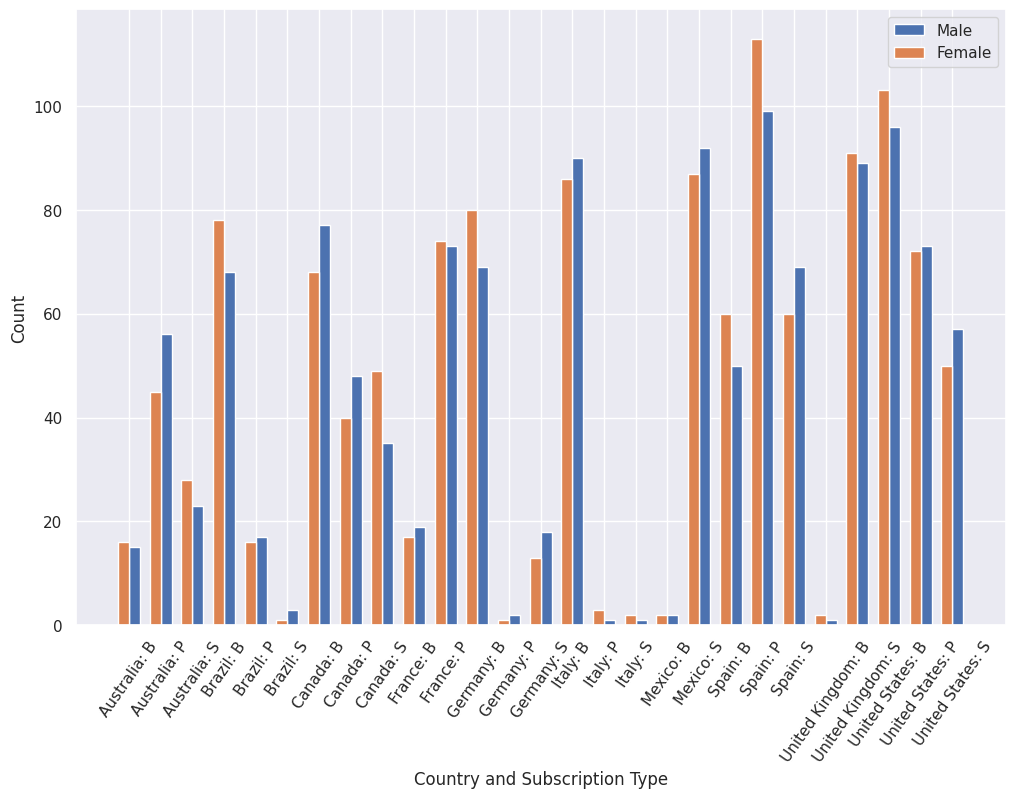

In [53]:
# Создаем переменные для данных графика
countries = grouped_data_two['country'].unique()

fig, ax = plt.subplots(figsize=(12, 8))

bar_width = 0.35
index = range(len(grouped_data_two))

bar1 = ax.bar([i + bar_width for i in index], grouped_data_two['Male'], bar_width, label='Male')
bar2 = ax.bar(index, grouped_data_two['Female'], bar_width, label='Female')

ax.set_xticks([i + bar_width / 2 for i in index])
ax.set_xticklabels([f"{country}: {subscription[0]}" for country, subscription in zip(grouped_data_two['country'], grouped_data_two['subscription_type'])])
ax.set_xlabel('Country and Subscription Type')
ax.set_ylabel('Count')

ax.legend()
plt.xticks(rotation=55)

plt.show()

In [54]:
#Создаем график оставляем этот !!!!
fig = px.bar(grouped_for_dots, x="country", y='users_count', color="subscription_type",
             barmode='group', labels={'users_count': 'Count', 'gender_for_dots': 'Gender', 'country': 'Country'},
             title='Number of Males and Females by Subscription Type', pattern_shape="gender_for_dots", pattern_shape_sequence=["", "x"])

# Наносим рисунок на столбцы, где gender_for_dots = Female
#for i, row in grouped_for_dots.iterrows():
   # if row['gender_for_dots'] == 'Female':
        #index_female = grouped_for_dots[grouped_for_dots['gender_for_dots'] == 'Female'].index.tolist()
       # fig.update_traces(marker=dict(symbol='x', color='black'), selector=dict(row=index_female))


#fig.update_traces(pattern_shape_sequence=[".", "x"])
# Отображаем график
fig.show()

In [55]:
# Меняем формат датафрейма для построения графика
melted_data = pd.melt(grouped_data_two, id_vars=['country', 'subscription_type'], var_name='gender', value_name='count').sort_values(by='gender',ascending=False)

# Строим интерактивный scatter plot с возможностью выбора пола
fig = px.scatter(melted_data, x='country', y='count', color='gender', facet_col='subscription_type',
                 title='User Counts by Gender in Different Countries and Subscription Types',
                 labels={'count': 'User Count', 'country': 'Country'},
                 height=600)

# Отображаем график
fig.show()

в plotly go есть drop down с элементом updatemenus здесь выбираем страну и тариф, а дальше на графике видим для мужчин и женщин количество пользователей по времени как менялось

In [56]:
netflix_dropdown = netflix_usb.copy()
netflix_dropdown.head()

,user_id,subscription_type,monthly_revenue,join_date,last_payment_date,country,age,gender,device,plan_duration_months
0,1,Basic,10,2022-01-15,2023-10-06,United States,28,Male,Smartphone,1
1,2,Premium,15,2021-05-09,2023-06-22,Canada,35,Female,Tablet,1
2,3,Standard,12,2023-02-28,2023-06-27,United Kingdom,42,Male,Smart TV,1
3,4,Standard,12,2022-10-07,2023-06-26,Australia,51,Female,Laptop,1
4,5,Basic,10,2023-01-05,2023-06-28,Germany,33,Male,Smartphone,1


In [57]:
# Подсчитать количество пользователей по возрастам - привяжи к финансам и странам (на разных графиках)
age_count = netflix_usb['age'].value_counts().reset_index().copy()
age_count.columns = ['age', 'count']
age_count.sort_values(by='age')
age_count.head()

,age,count
0,39,116
1,30,116
2,28,115
3,31,115
4,41,114


In [58]:
netflix_age_stype = netflix_usb.groupby(['country', 'age', 'subscription_type']).agg(customer_count=('user_id', 'count'), total_monthly_revenue=('monthly_revenue', 'sum')).reset_index()
netflix_age_stype

,country,age,subscription_type,customer_count,total_monthly_revenue
0,Australia,27,Basic,2,21
1,Australia,27,Premium,4,47
2,Australia,27,Standard,3,36
3,Australia,28,Basic,2,25
4,Australia,28,Premium,6,76
...,...,...,...,...,...
508,United States,50,Premium,3,37
509,United States,50,Standard,3,36
510,United States,51,Basic,7,89
511,United States,51,Premium,4,50


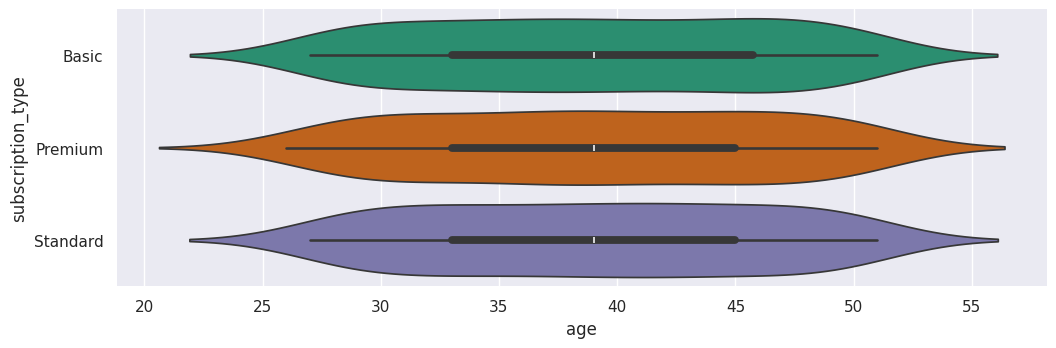

In [59]:
from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(netflix_age_stype['subscription_type'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(netflix_age_stype, x='age', y='subscription_type', inner='box', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

мы построили скрипичную диаграмму. В отличие от  от ящика с усами здесь мы визуализируем плотность значений по тарифам при распределении пользователей по возрастам. Распределение носит гармонический характери симметрично для всех типов тарифа (базовый, стандартный и премиальный). Наибольшее количество пользователей около 37-38 лет.

In [60]:
# Визуализация данных с помощью трехмерного scatter plot
fig = px.scatter_3d(netflix_age_stype, x='age', y='total_monthly_revenue', z='customer_count',
                    color='subscription_type', size='customer_count',
                    title='Relationship between Age, Total Monthly Revenue and Customer Count',
                    labels={'age': 'Age', 'total_monthly_revenue': 'Total Monthly Revenue', 'customer_count': 'Customer Count'},
                    height=600)

fig.update_layout(scene=dict(xaxis_title='Age', yaxis_title='Total Monthly Revenue', zaxis_title='Customer Count'))

# Отображаем график
fig.show()

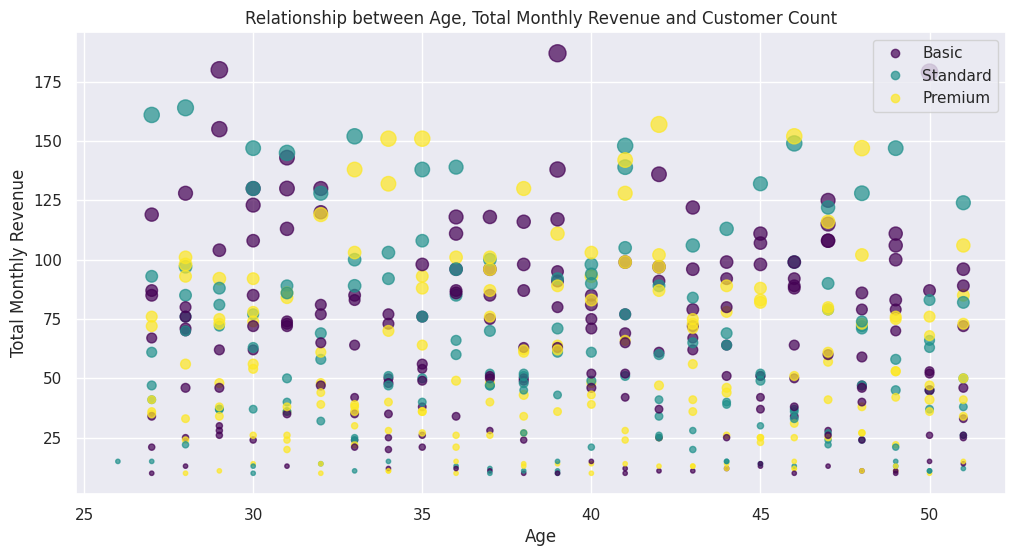

In [61]:
from sklearn.preprocessing import LabelEncoder
# Преобразуем категориальное значение 'subscription_type' в числовое
le = LabelEncoder()
netflix_age_stype['subscription_type_code'] = le.fit_transform(netflix_age_stype['subscription_type'])

# Создаем scatter plot
plt.figure(figsize=(12, 6))
scatter = plt.scatter(netflix_age_stype['age'], netflix_age_stype['total_monthly_revenue'],
            s=netflix_age_stype['customer_count']*10, c=netflix_age_stype['subscription_type_code'], alpha=0.7, cmap='viridis')

# Добавляем названия осей и заголовок
plt.xlabel('Age')
plt.ylabel('Total Monthly Revenue')
plt.title('Relationship between Age, Total Monthly Revenue and Customer Count')

# Добавляем легенду с указанием тарифов
#plt.colorbar(scatter, label='Subscription Type')
plt.legend(handles=scatter.legend_elements()[0], labels=['Basic', 'Standard', 'Premium'])

# Отображаем график
plt.show()

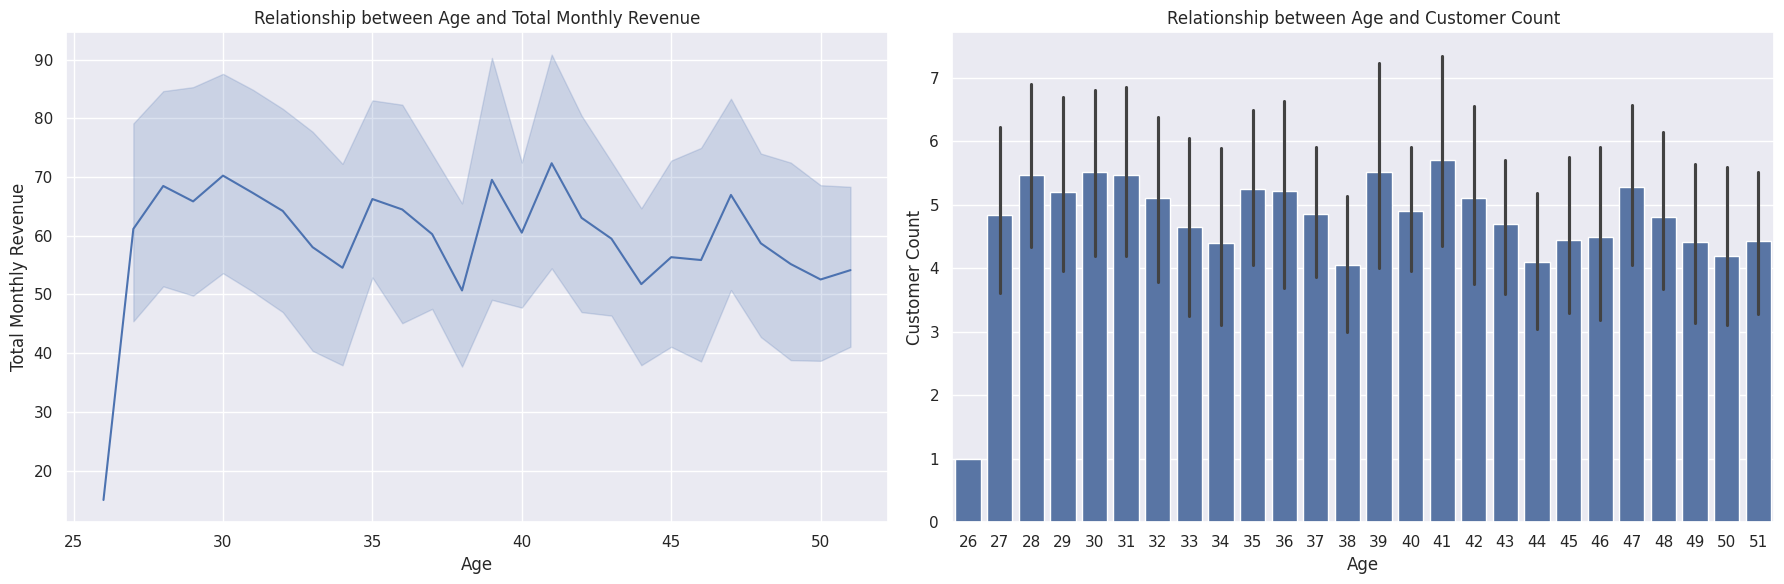

In [62]:
# Создаем Figure и Axes для обоих графиков
fig, axs = plt.subplots(1, 2, figsize=(18, 6))

# График 1: Взаимосвязь между возрастом и total_monthly_revenue (линейный график)
sns.lineplot(x='age', y='total_monthly_revenue', data=netflix_age_stype, ax=axs[0])
axs[0].set_xlabel('Age')
axs[0].set_ylabel('Total Monthly Revenue')
axs[0].set_title('Relationship between Age and Total Monthly Revenue')

# График 2: Взаимосвязь между возрастом и customer_count (столбчатая диаграмма)
sns.barplot(x='age', y='customer_count', data=netflix_age_stype, ax=axs[1])
axs[1].set_xlabel('Age')
axs[1].set_ylabel('Customer Count')
axs[1].set_title('Relationship between Age and Customer Count')

# Отображаем графики
plt.tight_layout()
plt.show()

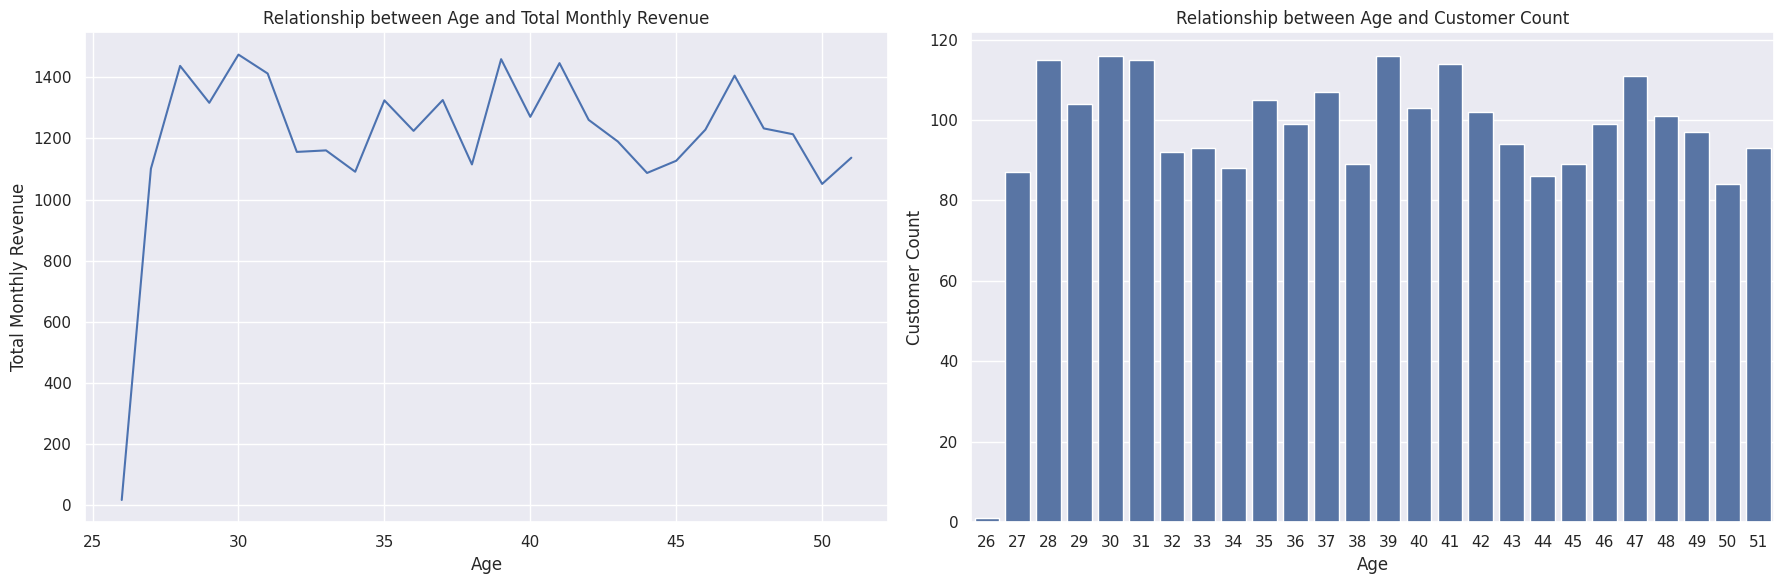

In [63]:
# Рассчитываем общий суммарный total_monthly_revenue и customer_count для каждого возраста
total_revenue_customer_per_age = netflix_age_stype.groupby('age').agg({'total_monthly_revenue': 'sum', 'customer_count': 'sum'}).reset_index()

# Создаем Figure и Axes для двух графиков
fig, axs = plt.subplots(1, 2, figsize=(18, 6))

# График 1: Взаимосвязь возраста и общего ежемесячного дохода
sns.lineplot(x='age', y='total_monthly_revenue', data=total_revenue_customer_per_age, ax=axs[0])
axs[0].set_xlabel('Age')
axs[0].set_ylabel('Total Monthly Revenue')
axs[0].set_title('Relationship between Age and Total Monthly Revenue')

# График 2: Взаимосвязь возраста и количества покупателей
sns.barplot(x='age', y='customer_count', data=total_revenue_customer_per_age, ax=axs[1])
axs[1].set_xlabel('Age')
axs[1].set_ylabel('Customer Count')
axs[1].set_title('Relationship between Age and Customer Count')

# Отображаем графики
plt.tight_layout()
plt.show()

допиши легенду+

In [64]:
netflix_ages_generations = netflix_usb.copy()
netflix_ages_generations['age_group'] = pd.cut(netflix_ages_generations['age'], bins=[0, 29, 39, float('inf')], labels=['у_1', 'у_2', 'x'])
# Группировка данных по стране и age_group, подсчет количества пользователей и добавление нового столбца "count"
netflix_ages_generations['count'] = netflix_ages_generations.groupby(['country', 'age_group'])['user_id'].transform('count')
netflix_ages_generations.head()


,user_id,subscription_type,monthly_revenue,join_date,last_payment_date,country,age,gender,device,plan_duration_months,age_group,count
0,1,Basic,10,2022-01-15,2023-10-06,United States,28,Male,Smartphone,1,у_1,58
1,2,Premium,15,2021-05-09,2023-06-22,Canada,35,Female,Tablet,1,у_2,143
2,3,Standard,12,2023-02-28,2023-06-27,United Kingdom,42,Male,Smart TV,1,x,91
3,4,Standard,12,2022-10-07,2023-06-26,Australia,51,Female,Laptop,1,x,85
4,5,Basic,10,2023-01-05,2023-06-28,Germany,33,Male,Smartphone,1,у_2,89


In [65]:
# Создаем отдельные датафреймы для Millennials и Generation X
millennials_data = netflix_ages_generations[netflix_ages_generations['age_group'].isin(['у_1', 'у_2'])]
gen_x_data = netflix_ages_generations[netflix_ages_generations['age_group'] == 'x']

# Строим карту для Millennials с цветовой схемой Viridis
fig_millennials = px.choropleth(millennials_data,
                                locations='country',
                                locationmode='country names',
                                color='count',
                                hover_name='country',
                                title='Number of Millennial Users by Country',
                                color_continuous_scale='Viridis'
                               )
fig_millennials.update_layout(coloraxis_colorbar_title='Users Count')
fig_millennials.show()

# Строим карту для Generation X с цветовой схемой Viridis
fig_gen_x = px.choropleth(gen_x_data,
                          locations='country',
                          locationmode='country names',
                          color='count',
                          hover_name='country',
                          title='Number of Generation X Users by Country',
                          color_continuous_scale='Viridis'
                         )
fig_gen_x.update_layout(coloraxis_colorbar_title='Users Count')
fig_gen_x.show()

сделай т-тест на доходы в рамказ каждой страны (поколенческий т-тест) и сразу станет понятнее
миллениалы и поколение х приносят одинаковый доход
н1 - различный доход

Отлично, мы видим, сколько пользователей к каким возрастным группам относятся. Теперь разобьем их на категории:
1. поколение Х - родились между 1964 и 1984, т.е. им около 40-60 лет
2. поколение У - миллениалы - родились между 1985-2002. т.е. им около 39-22 лет. Миллениалы представлены очень большим разбросом по возрасту, поделим их на две подгруппы:
У_1 - миллениалы от 22 до 30 лет
у_2 - миллениалы от 30 до 39 лет
Более младшие группы в нашем датафрейме не представлены

++ сделай боксплот по распределению возрастов по количество пользователей, не обязательно привязывать к возрастным группам + диаграмма распределения (гистограмма или kde plot - рисует распределения)


САША СКИНУЛ ВАРИАНТ ГРУППИРОВКИ, КОГДА МНОГО ДЕРГАННЫХ ЗНАЧЕНИЙ, А НУЖНЫ ИНТЕРВАЛЬНЫЕ ДАННЫЕ

ПРИВЯЖЕМ К КОЛИЧЕСТВУ УНИКАЛЬНЫХ КОМБИНАЦИЙ ТАРИФ+ВОЗРАСТ ШИРИНУ ЛИНИИ (ОНА. БУДЕТ ОТВЕЧАТЬ ЗА КОЛИЧЕСТВО УНИКАЛЬНЫХ ТАРИФОВ) СМОТРИ ПО СТРАНАМ
ПРЕДВАРИТЕЛЬНО БЫЛО БЫ ЗДОРОВО ОТСЕЧЬ ДАННЫЕ, КОТОРЫЕ НЕ ОТЛИЧАЮТСЯ, ЧТОБЫ СМОТРЕТЬ ИЗНАЧАЛЬНО НА ПОДРОБНОСТИ РАЗЛИЧНЫХ ДАННЫХ
Ты можешь добавить из сиборна errorbars
  таймлайн/количество пользователей, толщина линии это количество уникальныз з\начений тарифа

посмотреть в рамках одного возраста и тарифа по платежам и в рамках страны, что кто то платит 10, кто то платит 13 например, то есть я оставляю данные из датафрейма где есть эта разница, далее на х время а на у - количество этих тарифов. сдлеай через dropdown


сделай т-тест на доходы в рамказ каждой страны (поколенческий т-тест) и сразу станет понятнее миллениалы и поколение х приносят одинаковый доход н1 - различный доход

In [66]:
# Подсчет количества пользователей в каждой категории age_group
age_group_count = netflix_ages_generations['age_group'].value_counts().reset_index()
age_group_count.columns = ['age_group', 'count']

# Создание интерактивного кругового графика (пайчарта)
fig = px.pie(age_group_count,
             values='count',
             names='age_group',
             title='Distribution of Users by Age Group',
             labels={'age_group': 'Age Group'}
            )
fig.show()

In [67]:
# Фильтруем данные для Millennials и Generation X
millennials = netflix_ages_generations[netflix_ages_generations['age_group'].isin(['у_1', 'у_2'])]
gen_x = netflix_ages_generations[netflix_ages_generations['age_group'] == 'x']

# Группируем данные по странам
grouped_data = netflix_ages_generations.groupby('country')

# Выполняем t-тест для каждой страны
for country, data in grouped_data:
    millennials_country = data[data['age_group'].isin(['у_1', 'у_2'])]['monthly_revenue']
    gen_x_country = data[data['age_group'] == 'x']['monthly_revenue']

    t_statistic, p_value = ttest_ind(millennials_country, gen_x_country, equal_var=False)

    if p_value < 0.05:
        print(f'T-test for {country}: Reject the null hypothesis. Millennials and Generation X have different incomes.')
    else:
        print(f'T-test for {country}: Fail to reject the null hypothesis. Millennials and Generation X have similar incomes.')

T-test for Australia: Fail to reject the null hypothesis. Millennials and Generation X have similar incomes.
T-test for Brazil: Fail to reject the null hypothesis. Millennials and Generation X have similar incomes.
T-test for Canada: Fail to reject the null hypothesis. Millennials and Generation X have similar incomes.
T-test for France: Fail to reject the null hypothesis. Millennials and Generation X have similar incomes.
T-test for Germany: Fail to reject the null hypothesis. Millennials and Generation X have similar incomes.
T-test for Italy: Fail to reject the null hypothesis. Millennials and Generation X have similar incomes.
T-test for Mexico: Fail to reject the null hypothesis. Millennials and Generation X have similar incomes.
T-test for Spain: Fail to reject the null hypothesis. Millennials and Generation X have similar incomes.
T-test for United Kingdom: Fail to reject the null hypothesis. Millennials and Generation X have similar incomes.
T-test for United States: Fail to re

In [68]:
# Фильтруем данные для Millennials и Generation X
millennials = netflix_ages_generations[netflix_ages_generations['age_group'].isin(['у_1', 'у_2'])]
gen_x = netflix_ages_generations[netflix_ages_generations['age_group'] == 'x']

# Группируем данные по стране и тарифу
grouped_data = netflix_ages_generations.groupby(['country', 'subscription_type'])

# Создаем пустой список для хранения результатов t-теста
results = []

# Выполняем t-тест для каждой страны и тарифа
for group, data in grouped_data:
    millennials_group = data[data['age_group'].isin(['у_1', 'у_2'])]['monthly_revenue']
    gen_x_group = data[data['age_group'] == 'x']['monthly_revenue']

    t_statistic, p_value = ttest_ind(millennials_group, gen_x_group, equal_var=False)

    results.append({
        'Country': group[0],
        'Subscription Type': group[1],
        'T-Statistic': t_statistic,
        'P-Value': p_value,
        'Result': 'Reject H0' if p_value < 0.05 else 'Fail to Reject H0'
    })

# Создаем DataFrame из результатов и выводим в виде таблицы
results_df = pd.DataFrame(results)
results_df

,Country,Subscription Type,T-Statistic,P-Value,Result
0,Australia,Basic,0.320279,0.751084,Fail to Reject H0
1,Australia,Premium,0.110737,0.912053,Fail to Reject H0
2,Australia,Standard,-1.103323,0.275603,Fail to Reject H0
3,Brazil,Basic,1.257823,0.210616,Fail to Reject H0
4,Brazil,Premium,0.131933,0.895894,Fail to Reject H0
5,Brazil,Standard,-0.277350,0.810892,Fail to Reject H0
6,Canada,Basic,0.924334,0.356968,Fail to Reject H0
7,Canada,Premium,-0.572127,0.568744,Fail to Reject H0
8,Canada,Standard,-0.854153,0.395662,Fail to Reject H0
9,France,Basic,-1.653677,0.109819,Fail to Reject H0


In [69]:
# Создаем датафрейм для t-теста
netflix_age_ttest = netflix_ages_generations.copy()

# Группировка данных по стране, типу тарифа и возрастной группе для анализа доходов
results = []

#
for (country, subscription_type), group in netflix_age_ttest.groupby(['country', 'subscription_type']):
    millennials_data = group[group['age_group'].isin(['у_1', 'у_2'])]['monthly_revenue']
    gen_x_data = group[group['age_group'] == 'x']['monthly_revenue']

    if len(millennials_data) >= 32 and len(gen_x_data) >= 32:  # Проверяем, что есть хотя бы по 32 значения для ттеста
        t_stat, p_val = ttest_ind(millennials_data, gen_x_data, equal_var=False)

        result = {
            'country': country,
            'subscription_type': subscription_type,
            'p-value': p_val,
            'Null Hypothesis': 'Отклонена' if p_val < 0.05 else 'Не отклонена'
        }
        results.append(result)

# Вывод результатов
results_df = pd.DataFrame(results)
results_df

,country,subscription_type,p-value,Null Hypothesis
0,Australia,Premium,0.912053,Не отклонена
1,Brazil,Basic,0.210616,Не отклонена
2,Canada,Basic,0.356968,Не отклонена
3,Canada,Premium,0.568744,Не отклонена
4,Canada,Standard,0.395662,Не отклонена
5,France,Premium,0.541504,Не отклонена
6,Germany,Basic,0.949836,Не отклонена
7,Italy,Basic,0.582377,Не отклонена
8,Mexico,Standard,0.375806,Не отклонена
9,Spain,Basic,0.420785,Не отклонена


In [70]:
netflix_age_stype

,country,age,subscription_type,customer_count,total_monthly_revenue,subscription_type_code
0,Australia,27,Basic,2,21,0
1,Australia,27,Premium,4,47,1
2,Australia,27,Standard,3,36,2
3,Australia,28,Basic,2,25,0
4,Australia,28,Premium,6,76,1
...,...,...,...,...,...,...
508,United States,50,Premium,3,37,1
509,United States,50,Standard,3,36,2
510,United States,51,Basic,7,89,0
511,United States,51,Premium,4,50,1


In [71]:
# Создаем боксплот для распределения возрастов по количеству пользователей
fig = px.box(netflix_age_stype, x='age', y='customer_count',
             labels={'age': 'Age', 'user_count': 'Number of Users'},
             title='Distribution of Age by Number of Users')

# Отображаем боксплот
fig.show()

вывод: видим выбросы для возраста 29 лет (12 и 14 пользователей), 38 лет ( максимум 10 пользователей), 39 лет (выборс в 15 пользователей) и 50 лет (выброс в 14 пользователей)
Условно в правой части боксплотов т.е. от среднего взозраста в 37 лет и до более старшего, мы видим большую дисперсию (т.е. разброс значений относительно медианы), при этом в левой части графика (более молодая аудитория) разброс меньше. При этом какой то тендеции в изменении медианных значений не выявлено.
Интересно было бы дозапросить данные в связи с большим разброс количества пользователей по тарифам и странам в более старшей аудитории: по-разному работали маркетинговые кампании? Или сами тарифы не были всегда доступны для покупки?

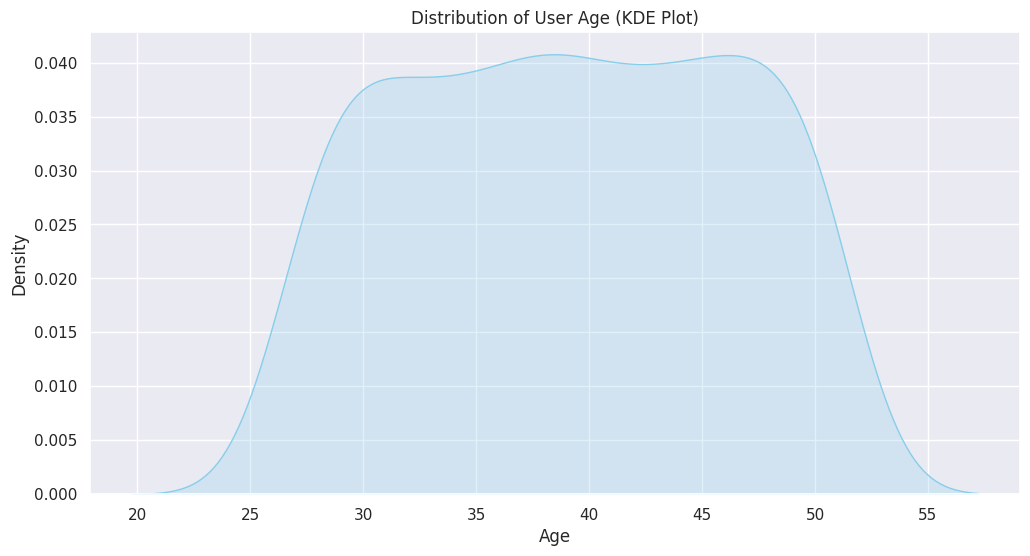

In [72]:
# Создаем KDE plot для распределения возрастов пользователей
plt.figure(figsize=(12, 6))
sns.kdeplot(data=netflix_age_stype, x='age', fill=True, color='skyblue')
plt.title('Distribution of User Age (KDE Plot)')
plt.xlabel('Age')
plt.ylabel('Density')
plt.show()

На графике KDE (Kernel Density Estimation) это значение, обозначенное по шкале y, представляет собой оценку плотности вероятности для каждого значения возраста, то есть вероятность встретить конкретное значение возраста в распределении. Чем выше значение на оси y в какой-то точке графика, тем более вероятно встретить возраст, соответствующий этой точке.

График KDE показывает, как плотность вероятности изменяется с изменением возраста. Это визуальное представление распределения, которое позволяет увидеть, в каких диапазонах возрастов вероятность более высокая или ниже.

Построение графика KDE позволяет аппроксимировать форму распределения данных, делая его более плавным и удобным для визуализации, чем обычная гистограмма.

In [73]:
# Отфильтруем данные, чтобы исключить дубликаты и оставить только уникальные комбинации тарифов и возрастов
netflix_age_stype_unique = netflix_usb.drop_duplicates(subset=['subscription_type', 'age']).copy()

# Создадим столбец 'line_width' со значением, равным количеству уникальных тарифов
netflix_age_stype_unique['line_width'] = netflix_age_stype_unique.groupby('country')['subscription_type'].transform('nunique')

# Просмотрим полученный датафрейм
netflix_age_stype_unique.head()

,user_id,subscription_type,monthly_revenue,join_date,last_payment_date,country,age,gender,device,plan_duration_months,line_width
0,1,Basic,10,2022-01-15,2023-10-06,United States,28,Male,Smartphone,1,2
1,2,Premium,15,2021-05-09,2023-06-22,Canada,35,Female,Tablet,1,3
2,3,Standard,12,2023-02-28,2023-06-27,United Kingdom,42,Male,Smart TV,1,1
3,4,Standard,12,2022-10-07,2023-06-26,Australia,51,Female,Laptop,1,3
4,5,Basic,10,2023-01-05,2023-06-28,Germany,33,Male,Smartphone,1,3


In [74]:
# Создать новую колонку с группами возрастов
netflix_ages =netflix_usb.copy()
netflix_ages['age_group'] = pd.cut(netflix_usb['age'], bins=[0, 29, 39, float('inf')], labels=['у_1', 'у_2', 'x'])

netflix_ages.head()

,user_id,subscription_type,monthly_revenue,join_date,last_payment_date,country,age,gender,device,plan_duration_months,age_group
0,1,Basic,10,2022-01-15,2023-10-06,United States,28,Male,Smartphone,1,у_1
1,2,Premium,15,2021-05-09,2023-06-22,Canada,35,Female,Tablet,1,у_2
2,3,Standard,12,2023-02-28,2023-06-27,United Kingdom,42,Male,Smart TV,1,x
3,4,Standard,12,2022-10-07,2023-06-26,Australia,51,Female,Laptop,1,x
4,5,Basic,10,2023-01-05,2023-06-28,Germany,33,Male,Smartphone,1,у_2


In [75]:
netflix_ages = netflix_ages[['user_id', 'subscription_type', 'monthly_revenue', 'join_date', 'country', 'age', 'gender', 'device', 'age_group']]
netflix_ages.head()

,user_id,subscription_type,monthly_revenue,join_date,country,age,gender,device,age_group
0,1,Basic,10,2022-01-15,United States,28,Male,Smartphone,у_1
1,2,Premium,15,2021-05-09,Canada,35,Female,Tablet,у_2
2,3,Standard,12,2023-02-28,United Kingdom,42,Male,Smart TV,x
3,4,Standard,12,2022-10-07,Australia,51,Female,Laptop,x
4,5,Basic,10,2023-01-05,Germany,33,Male,Smartphone,у_2


LTV (Lifetime Value)  представляет собой общую сумму денег, которую пользователь принесет компании за всё время его жизни как клиента.

Для расчета LTV на основе данных из датафрейма `netflix_usb` важно знать точные значения ARPU, LTV. ARPU можно вычислить как отношение общего дохода к количеству пользователей за определенный период. LTV можно рассчитать на основе данных о том, как долго пользователь остается клиентом.

После расчета LTV для каждого пользователя, можно провести анализ, например, выявить категории пользователей с наибольшим LTV и понять, какие действия компании могут помочь увеличить общий LTV.

При необходимости усреднить LTV по периодам, можно просуммировать LTV для всех пользователей за каждый период и поделить на количество пользователей.



разница между last payment date и join date и есть

In [76]:
netflix_usb.head()

,user_id,subscription_type,monthly_revenue,join_date,last_payment_date,country,age,gender,device,plan_duration_months
0,1,Basic,10,2022-01-15,2023-10-06,United States,28,Male,Smartphone,1
1,2,Premium,15,2021-05-09,2023-06-22,Canada,35,Female,Tablet,1
2,3,Standard,12,2023-02-28,2023-06-27,United Kingdom,42,Male,Smart TV,1
3,4,Standard,12,2022-10-07,2023-06-26,Australia,51,Female,Laptop,1
4,5,Basic,10,2023-01-05,2023-06-28,Germany,33,Male,Smartphone,1


In [77]:
netflix_ltv = netflix_usb.copy()
# Преобразуем столбцы join_date и last_payment_date в формат datetime
netflix_ltv['join_date'] = pd.to_datetime(netflix_ltv['join_date'])
netflix_ltv['last_payment_date'] = pd.to_datetime(netflix_ltv['last_payment_date'])

# Рассчитываем Lifetime Value (LTV) как разницу между last_payment_date и join_date, умноженную на monthly_revenue
netflix_ltv['ltv'] = netflix_ltv['monthly_revenue'] * ((netflix_ltv['last_payment_date'] - netflix_ltv['join_date']).dt.days / 30).round(2)

# Выводим датафрейм с добавленным столбцом LTV
netflix_ltv = netflix_ltv[['user_id', 'subscription_type', 'ltv', 'country']]
netflix_ltv

,user_id,subscription_type,ltv,country
0,1,Basic,209.70,United States
1,2,Premium,387.00,Canada
2,3,Standard,47.64,United Kingdom
3,4,Standard,104.76,Australia
4,5,Basic,58.00,Germany
...,...,...,...,...
2495,2496,Premium,233.38,Spain
2496,2497,Basic,231.00,Spain
2497,2498,Standard,123.96,United States
2498,2499,Standard,157.69,Canada


In [78]:
# Группируем данные по странам и тарифам, и считаем среднее значение ltv
avg_ltv_by_country_subscription = netflix_ltv.groupby(['country', 'subscription_type'])['ltv'].mean().round(2).reset_index()

avg_ltv_by_country_subscription.sort_values(by='ltv', ascending=False)



,country,subscription_type,ltv
5,Brazil,Standard,168.84
0,Australia,Basic,151.40
22,United Kingdom,Basic,146.33
9,France,Basic,142.43
23,United Kingdom,Standard,140.91
10,France,Premium,139.87
26,United States,Standard,139.29
1,Australia,Premium,137.99
16,Italy,Standard,137.93
19,Spain,Basic,137.39


In [79]:
# Создаем интерактивный график с градиентом, где цвет зависит от значения ltv
fig = px.scatter(avg_ltv_by_country_subscription, x='country', y='subscription_type', color='ltv',
                 color_continuous_scale='Viridis', size='ltv', hover_data=['ltv'])
fig.update_traces(marker=dict(line=dict(width=2, color='DarkSlateGrey')))
fig.update_layout(title='Average LTV by Country and Subscription Type', xaxis_title='Country', yaxis_title='Subscription Type')
fig.show()

C точки зрения средней суммарной прибыли на пользователя самыми выгодными тарифами и странами являются:
1. Бразилия - стандартный (168.84)
2. Австралия - базовый (151.40)
3. Великобритания - базовый (146.33)

А наименее выгодные:
1. Мексика - базовый (93.55)
2. Италия - премиальный (106,38)
3. Германия - премиальный (118.81)

При формировании стратегии привлечения новых клиентов имеет смысл обратить внимание именно на топ-3 стран/тарифов, а с другой стороны было бы интересно посмотреть аналитику по странам и тарифам с низким LTV. Почему такие невысокие показатели? может быть дело в том, что тариф имел какой то срок годности  (и например нельзя его дальше было продлить)? Или были другие причины? Здесь имеет смысл разработать стратегию именно по увеличению оставаемость пользователей в компании.

теперь разберемся со столбцом rolling retention:

retention - какая доля вовзращается на определенный день
rolling retention - смотрим пользователей, которые пришли на первый день и на любой после него - оценка, скольок людей пришли в конкретную дату или после нее
для rolling retention группируем людей по последней дате и вычитаем их из общего количества людей. Эта сумма постоянно сохраняется и получившийся результат делим на общее число людей.

retention не может быть больше 100%


по каждому тарифу/стране определим месяц, когда было наибольшее количество пользователей активно:

In [80]:
df = netflix_usb.copy()
df['join_date'] = pd.to_datetime(df['join_date'])

# создаем столбец с месяцем и годом
df['year_month'] = df['join_date'].dt.to_period('M')

# группируем по стране, тарифу и году и считаем количество пользователей
result = df.groupby(['country', 'subscription_type', 'year_month']).size().reset_index(name='user_count')

# находим максимальное количество пользователей для каждой страны и тарифа
max_users = result.groupby(['country', 'subscription_type'])['user_count'].max().reset_index()

# объединяем данные максимального количества пользователей с исходными данными
final_result = pd.merge(max_users, result, on=['country', 'subscription_type', 'user_count'], how='left')

final_result.sort_values(by='user_count', ascending=False)


,country,subscription_type,user_count,year_month
25,Spain,Premium,47,2022-10
31,United States,Basic,36,2022-10
30,United Kingdom,Standard,35,2022-07
17,Italy,Basic,33,2022-10
23,Mexico,Standard,30,2022-10
3,Brazil,Basic,27,2022-07
32,United States,Premium,26,2022-07
13,France,Premium,25,2022-10
26,Spain,Standard,25,2022-10
9,Canada,Basic,25,2022-07


In [81]:
netflix_rolling_retention = netflix_usb.copy()
# Преобразуем столбцы join_date и last_payment_date в формат datetime
netflix_rolling_retention['join_date'] = pd.to_datetime(netflix_rolling_retention['join_date'])
netflix_rolling_retention['last_payment_date'] = pd.to_datetime(netflix_rolling_retention['last_payment_date'])

# Создаем столбец с месяцем подключения
netflix_rolling_retention['join_month'] = netflix_rolling_retention['join_date'].dt.to_period('M')

# Считаем количество уникальных пользователей в каждом месяце подключения
unique_users = netflix_rolling_retention.groupby('join_month')['user_id'].nunique()

# Считаем rolling retention
rolling_retention = unique_users.shift(-1) / unique_users

# Добавляем rolling retention обратно в датафрейм
netflix_rolling_retention['rolling_retention'] = netflix_rolling_retention['join_month'].map(rolling_retention)

# Создаем новый датафрейм netflix_rolling_retention с необходимыми столбцами
netflix_rolling_retention = netflix_rolling_retention[['user_id', 'rolling_retention', 'country']]

# Выводим датафрейм с Rolling Retention
netflix_rolling_retention

,user_id,rolling_retention,country
0,1,1.074074,United States
1,2,0.333333,Canada
2,3,1.200000,United Kingdom
3,4,0.281928,Australia
4,5,0.714286,Germany
...,...,...,...
2495,2496,0.740458,Spain
2496,2497,1.216981,Spain
2497,2498,1.378738,United States
2498,2499,0.073684,Canada


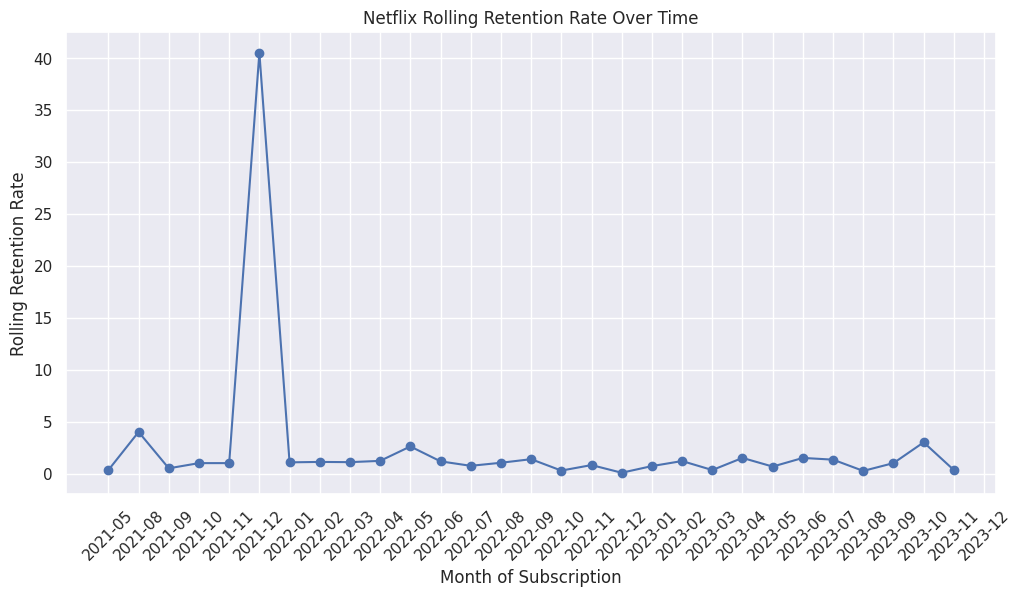

In [82]:
# Визуализируем Rolling Retention
plt.figure(figsize=(12, 6))
plt.plot(rolling_retention.index.astype(str), rolling_retention.values, marker='o', color='b')
plt.xlabel('Month of Subscription')
plt.ylabel('Rolling Retention Rate')
plt.title('Netflix Rolling Retention Rate Over Time')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()